In [3]:
from lemaitre import bandpasses
filterlib=bandpasses.get_filterlib()

2025-02-21 04:53:05,804 INFO loading lemaitre filterlib from /global/homes/a/agillesl/.cache/bbf/lemaitre_flib.default.0b8479e36fca60c99e76ea84d98cbe0c7383608814cddfaef21626fdf668b5c5.pkl


In [4]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm import tqdm
import pickle
import jax.numpy as jnp


In [5]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [6]:
%matplotlib inline

In [7]:
%load_ext line_profiler

In [8]:
survey_colors=dict(ZTF="tab:blue",
                   SNLS="tab:orange",
                   HSC="tab:green")

# Galaxies

In [7]:
abacus = [pandas.read_csv(f"/pscratch/sd/a/agillesl/Documents/Abacus/Abacus_zmax0.2_{i:03d}.csv", index_col=0)
         for i in tqdm(range(25))]

  0%|          | 0/25 [00:00<?, ?it/s]

In [9]:
uchuu_full = pandas.read_csv("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/Uchuu_full.csv")

In [10]:
uchuu_full = uchuu_full[uchuu_full.z < 0.5]

In [11]:
uchuu_full["in_desi"] = (uchuu_full.status & 2 != 0)

In [8]:
z_max = 0.5
n_bins = 15
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)


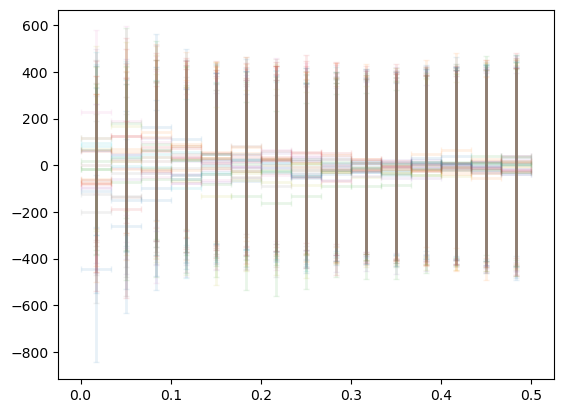

In [10]:
abacus_means = []
abacus_std = []
for bgs in abacus:
    pv = (bgs.z - bgs.z_cosmo)/(1+ bgs.z_cosmo)*c*1e-3
    in_bins = [(bgs.z.values > z_min) & (bgs.z < z_min + width) for z_min in bounds]


    # plt.scatter(bgs[bgs.z < 0.2].z[::10], pv[bgs.z < 0.2][::10], alpha=.2, marker=".", s=1)
    abacus_means.append([pv[filt].mean() for filt in in_bins])
    abacus_std.append([pv[filt].std() for filt in in_bins])
    plt.errorbar(bounds + width/2,
                 abacus_means[-1],
                 yerr=abacus_std[-1],
                 xerr=width/2,
                 linestyle='',
                 #color='blue',
                 linewidth=2,
                 alpha=0.1,
                 capsize=2)
abacus_means = np.vstack(abacus_means)
abacus_std = np.vstack(abacus_std)

In [30]:
uchuu_full['pv'] = (uchuu_full.z - uchuu_full.z_cosmo)/(1+ uchuu_full.z_cosmo)*c*1e-3

in_bins_uchuu = [(uchuu_full[uchuu_full.in_desi].z > z_min) & (uchuu_full[uchuu_full.in_desi].z < z_min + width) for z_min in bounds]

in_bins_uchuu_full = [(uchuu_full.z > z_min) & (uchuu_full.z < z_min + width) for z_min in bounds]

In [31]:
uchuu_desi_bins_means = [uchuu_full[uchuu_full.in_desi].pv[filt].mean() for filt in in_bins_uchuu]
uchuu_desi_bins_stds = [uchuu_full[uchuu_full.in_desi].pv[filt].std() for filt in in_bins_uchuu]

uchuu_full_bins_means = [uchuu_full.pv[filt].mean() for filt in in_bins_uchuu_full]
uchuu_full_bins_stds = [uchuu_full.pv[filt].std() for filt in in_bins_uchuu_full]


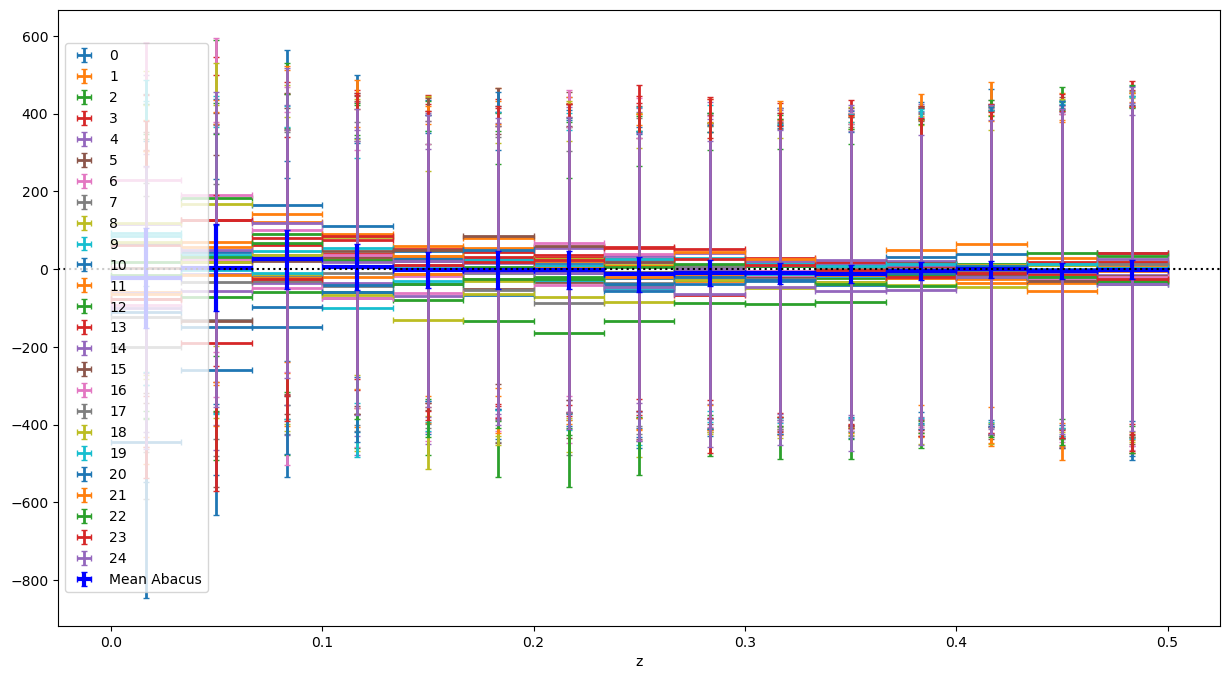

In [24]:
plt.figure(figsize=(15,8))
for i in range(25):
    plt.errorbar(bounds + width/2,
                 abacus_means[i],
                 yerr=abacus_std[i],
                 xerr=width/2,
                 linestyle='',
                 # alpha=0.1,
                 # color='tab:blue',
                 linewidth=2,
                 capsize=2,
                 label=f"{i}")
plt.errorbar(bounds + width/2,
             abacus_means.mean(axis=0),
             yerr=abacus_means.std(axis=0),
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=3,
             capsize=2,
             label='Mean Abacus')

plt.axhline(0, color="k", linestyle=':')
plt.xlabel("z")

plt.legend()

In [ ]:

plt.errorbar(bounds + width/2,
             uchuu_full_bins_means,
             yerr=uchuu_full_bins_stds,
             xerr=width/2,
             linestyle='',
             color='tab:green',
             linewidth=2,
             capsize=2,
             label='Uchuu fullsky')
plt.errorbar(bounds + width/2,
             uchuu_desi_bins_means,
             yerr=uchuu_desi_bins_stds,
             xerr=width/2,
             linestyle='',
             color='tab:orange',
             linewidth=2,
             capsize=2,
             label='Uchuu DESI footprint')



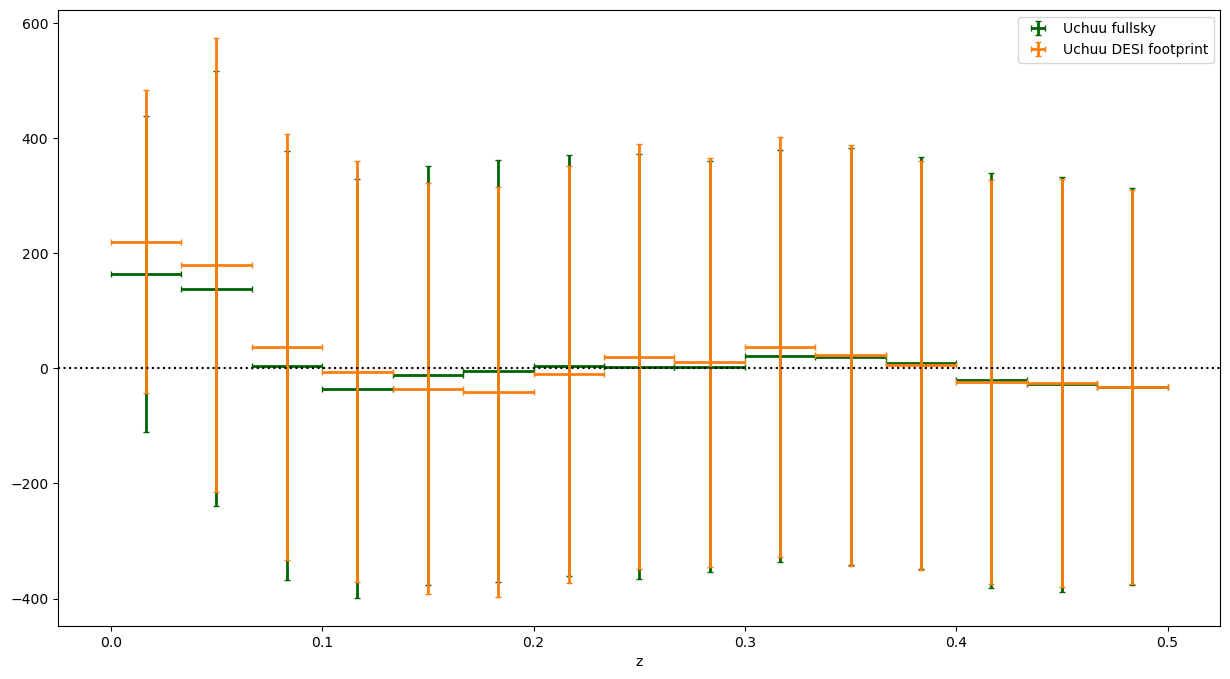

In [33]:
plt.figure(figsize=(15,8))
plt.errorbar(bounds + width/2,
             uchuu_full_bins_means,
             yerr=uchuu_full_bins_stds,
             xerr=width/2,
             linestyle='',
             color='darkgreen',
             linewidth=2,
             capsize=2,
             label='Uchuu fullsky')
plt.errorbar(bounds + width/2,
             uchuu_desi_bins_means,
             yerr=uchuu_desi_bins_stds,
             xerr=width/2,
             linestyle='',
             color='tab:orange',
             linewidth=2,
             capsize=2,
             label='Uchuu DESI footprint')


plt.axhline(0, color="k", linestyle=':')
plt.xlabel("z")

plt.legend()

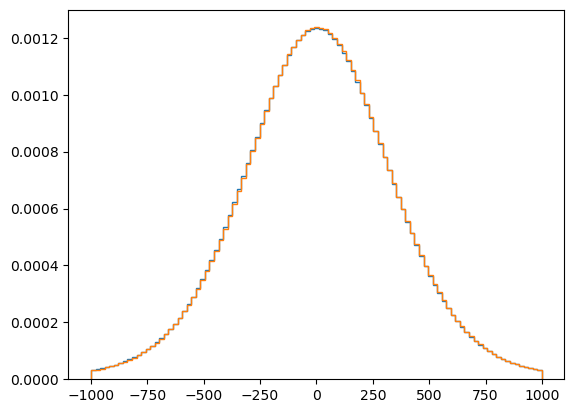

In [38]:
_=plt.hist(uchuu_full.pv, bins=np.linspace(-1000,1000,100), histtype='step', density=True)
_=plt.hist(uchuu_full.pv[uchuu_full.in_desi], bins=np.linspace(-1000,1000,100), histtype='step', density=True)

In [59]:
print(f"Full footprint : mean={uchuu_full.pv.mean():.4g}, std={uchuu_full.pv.std():4g}")
print(f"DESI footprint : mean={uchuu_full[uchuu_full.in_desi].pv.mean():.4g}, std={uchuu_full[uchuu_full.in_desi].pv.std():4g}")

Full footprint : mean=3.455, std=364.071
DESI footprint : mean=5.055, std=363.62


In [40]:
nside = 128
hmap = np.zeros(healpy.nside2npix(nside))
nb = np.zeros(healpy.nside2npix(nside))
hpix = healpy.ang2pix(nside,
                      np.pi/2 - (uchuu_full["dec"] * np.pi / 180),
                      (uchuu_full["ra"] - 360 * (uchuu_full["ra"] > 180)) * np.pi / 180)

for vp, pix in zip(uchuu_full.pv, hpix):
    hmap[pix] += vp
    nb[pix] += 1

hmap[nb!=0] = hmap[nb!=0]/nb[nb!=0]

In [41]:
hmap = healpy.smoothing(hmap, fwhm=0.07)


2024-12-13 06:54:59,693 INFO Sigma is 102.191365 arcmin (0.029726 rad) 
2024-12-13 06:54:59,694 INFO -> fwhm is 240.642274 arcmin
2024-12-13 06:54:59,695 INFO Sigma is 0.000000 arcmin (0.000000 rad) 
2024-12-13 06:54:59,696 INFO -> fwhm is 0.000000 arcmin


In [42]:
res = healpy.pixelfunc.fit_dipole(hmap)
healpy.vec2ang(res[1], lonlat=True)

(array([18.56913031]), array([-27.82210311]))

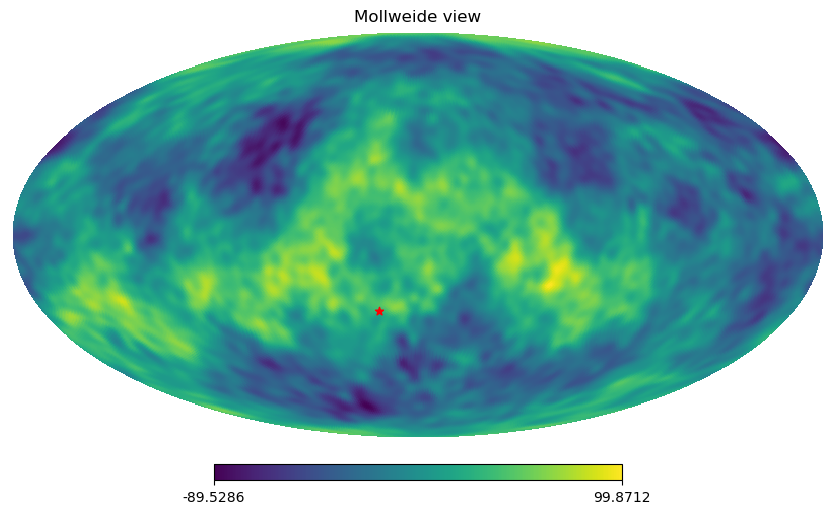

In [43]:
healpy.mollview(hmap,)
healpy.projscatter(healpy.vec2ang(res[1]), marker='*', color='red')

In [55]:
nside = 128
hmap_desi = np.zeros(healpy.nside2npix(nside))
nb_desi = np.zeros(healpy.nside2npix(nside))
hpix_desi = healpy.ang2pix(nside,
                      np.pi/2 - (uchuu_full[uchuu_full.in_desi]["dec"] * np.pi / 180),
                      (uchuu_full[uchuu_full.in_desi]["ra"] - 360 * (uchuu_full[uchuu_full.in_desi]["ra"] > 180)) * np.pi / 180)

for vp, pix in zip(uchuu_full.pv, hpix_desi):
    hmap_desi[pix] += vp
    nb_desi[pix] += 1

hmap_desi[nb_desi!=0] = hmap_desi[nb_desi!=0]/nb_desi[nb_desi!=0]



In [56]:
hmap_desi = healpy.smoothing(hmap_desi, fwhm=0.07)

2024-12-13 06:56:12,827 INFO Sigma is 102.191365 arcmin (0.029726 rad) 
2024-12-13 06:56:12,827 INFO -> fwhm is 240.642274 arcmin
2024-12-13 06:56:12,828 INFO Sigma is 0.000000 arcmin (0.000000 rad) 
2024-12-13 06:56:12,828 INFO -> fwhm is 0.000000 arcmin


In [57]:
res_desi = healpy.pixelfunc.fit_dipole(hmap_desi)
healpy.vec2ang(res_desi[1], lonlat=True)

(array([195.14918853]), array([75.28933448]))

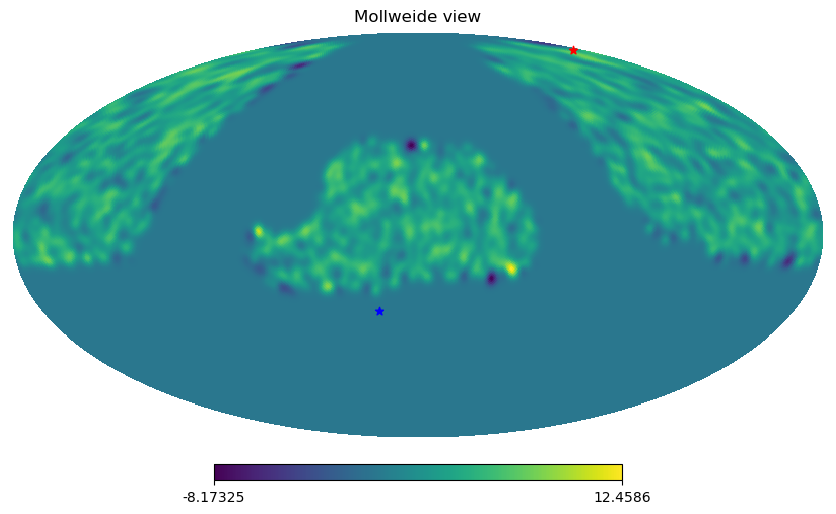

In [58]:
healpy.mollview(hmap_desi,)
healpy.projscatter(healpy.vec2ang(res[1]), marker='*', color='blue')
healpy.projscatter(healpy.vec2ang(res_desi[1]), marker='*', color='red')

In [47]:
pantheon = pandas.read_csv('data/Pantheon_+.csv')

In [48]:
pantheon.rename(columns={"RA":"ra", "Dec":"dec"}, inplace=True)

2024-12-13 06:55:13,481 WARNING Pandas support in corner is deprecated; use ArviZ directly


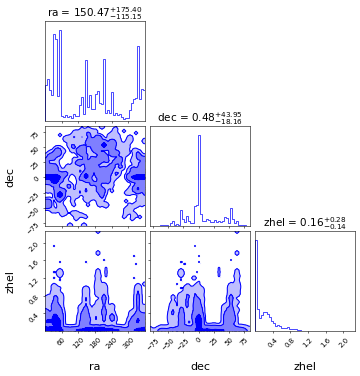

In [49]:
_=corner_(pantheon, var_names=["ra", "dec", "zhel"])

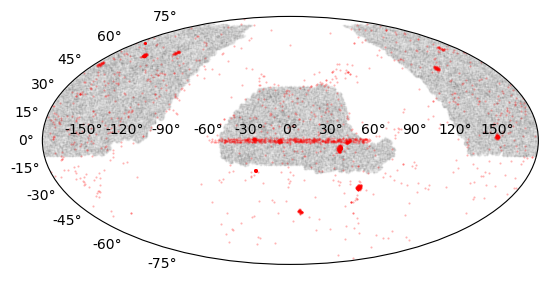

In [50]:
scatter_mollweide(bgs[::100], alpha=.01)
scatter_mollweide(pantheon, ax = plt.gca(), color="red")

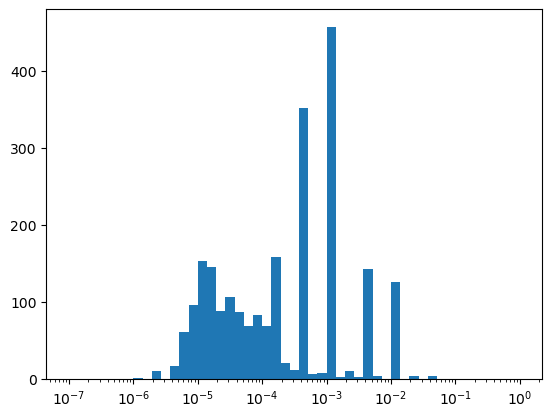

In [22]:
plt.hist(pantheon.zhelerr, bins=np.logspace(-7, 0))
plt.xscale("log")

In [15]:
uchuu_host=[]
for index, sn in tqdm(pantheon[pantheon.zhel < 0.7].iterrows(), total=len(pantheon[pantheon.zhel < 0.7])):
    z_sel = bgs[bgs.z.between(sn.zhel - 1e-3, sn.zhel + 1e-3)]
    hosts=z_sel[z_sel.ra.between(sn.ra - 10, sn.ra + 10) & z_sel.dec.between(sn.dec - 10, sn.dec + 10)]
    uchuu_host.append(hosts)

  0%|          | 0/2126 [00:00<?, ?it/s]

In [16]:
for idx, idx_p in tqdm(enumerate(pantheon[pantheon.zhel < 0.7].index), total=len(pantheon[pantheon.zhel < 0.7])):
    uchuu_host[idx]['score'] = (uchuu_host[idx].z - pantheon.loc[idx_p, "zhel"])**2 + \
                                (uchuu_host[idx].ra - pantheon.loc[idx_p, "ra"])**2 + \
                                (uchuu_host[idx].dec - pantheon.loc[idx_p, "dec"])**2

  0%|          | 0/2126 [00:00<?, ?it/s]

/tmp/ipykernel_1631181/2652606212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uchuu_host[idx]['score'] = (uchuu_host[idx].z - pantheon.loc[idx_p, "zhel"])**2 + \


In [17]:
id_bgs = np.array([uchuu_host[idx].index[uchuu_host[idx].score.argmin()] if len(uchuu_host[idx]) > 0 else -1 for idx in tqdm(range(len(uchuu_host)))])
id_bgs = id_bgs[id_bgs != -1]

  0%|          | 0/2126 [00:00<?, ?it/s]

In [18]:
n_draw = 100
vps = []
redshifts = []
for d in range(n_draw):
    id_bgs_rdm = np.array([uchuu_host[idx].index[np.random.randint(0, len(uchuu_host[idx]))] if len(uchuu_host[idx]) > 0 else -1 for idx in tqdm(range(len(uchuu_host)), leave=False)])

    id_bgs_rdm = id_bgs_rdm[id_bgs_rdm != -1]
    pantheon_uchuu_rdm = bgs.loc[id_bgs_rdm].copy()
    pantheon_uchuu_vp_rdm = (pantheon_uchuu_rdm.z - pantheon_uchuu_rdm.z_cosmo)/(1+ pantheon_uchuu_rdm.z_cosmo)*c*1e-3
    vps.append(np.array(pantheon_uchuu_vp_rdm))
    redshifts.append(np.array(pantheon_uchuu_rdm.z))

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

  0%|          | 0/2126 [00:00<?, ?it/s]

In [19]:
redshit_pantheon = pantheon[(pantheon.zhel < 0.7)][np.array([len(uchuu_host[i])!= 0 for i in range(len(uchuu_host))])].zhel

/tmp/ipykernel_1631181/2552338121.py:24: RuntimeWarning: invalid value encountered in sqrt
  yerr=[np.std([vp[filt].mean() for vp in vps])/len(np.sqrt(vps)) for filt in in_bins],


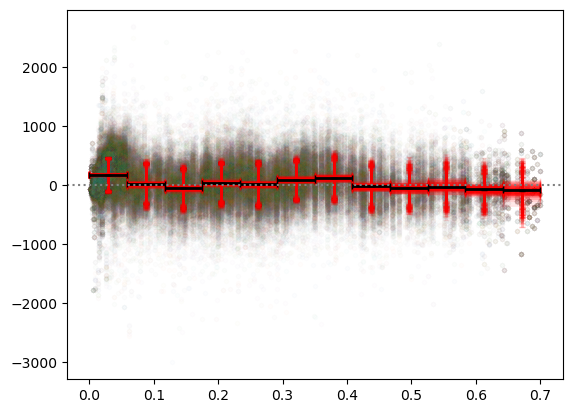

In [20]:
for vp in vps:
    plt.scatter(redshit_pantheon, vp, marker='.', alpha=0.01)

z_max = 0.7
n_bins = 12
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)
in_bins = [(redshit_pantheon.values > z_min) & (redshit_pantheon.values < z_min + width) for z_min in bounds]

    
for vp in vps:
    plt.errorbar(bounds + width/2,
                 [vp[filt].mean() for filt in in_bins],
                 yerr=[vp[filt].std() for filt in in_bins],
                 xerr=width/2,
                 linestyle='',
                 color='red',
                 linewidth=2,
                 capsize=2,
                 alpha=0.1)

plt.errorbar(bounds + width/2,
         [np.mean([vp[filt].mean() for vp in vps]) for filt in in_bins],
         yerr=[np.std([vp[filt].mean() for vp in vps])/len(np.sqrt(vps)) for filt in in_bins],
         xerr=width/2,
         linestyle='',
         color='black',
         linewidth=2,
         capsize=2)

plt.axhline(0, color='grey', linestyle=':')

# Uchuu thingies

### Generation

In [10]:
lightcurves, fieldids = skysurvey.DataSet.realize_survey_target_lcs(snia, survey, incl_error=True)


/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")


  0%|          | 0/35712 [00:00<?, ?it/s]

In [54]:
dset=skysurvey.DataSet(lc.reset_index(survey.fieldids.names), targets=snia, survey=survey)

In [110]:
with open('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/pets_dataset_uchuu_0.2.pkl', 'rb') as file:
    data = pickle.load(file)
    lc = pickle.load(file)

### Spectra

In [59]:
data

z     x1      c          tmax          ra       dec     magabs  \
0      1.20115  0.955  0.025  59378.484375  151.738312  1.680526 -19.378025   
1      0.58555 -0.620 -0.056  58647.289062  150.155212  1.897260 -19.440180   
2      1.19235 -0.575 -0.091  58100.578125   34.103642 -5.078455 -19.569685   
3      1.15095 -1.980  0.114  58244.125000  150.491989  3.456182 -18.765671   
4      1.22865  0.150  0.245  59723.726562   36.358917 -3.787839 -18.651947   
...        ...    ...    ...           ...         ...       ...        ...   
23868  1.20715  0.555  0.045  59824.718750   36.974926 -4.380023 -19.366634   
23869  1.11545 -0.145  0.115  57772.167969   36.035839 -5.081779 -18.994186   
23870  0.96365 -0.035  0.123  58983.382812  150.251175  2.398554 -19.072275   
23871  1.35035 -1.420 -0.006  59558.312500  149.062897  2.849623 -19.051491   
23872  1.39015  1.755 -0.030  59013.746094   36.336380 -5.531566 -19.600128   

          mwebv     magobs            x0 template         sn survey  
0      0.040289  25.272352  1.243020e-06     None      HSC_0    HSC  
1      0.021486  23.298866  7.653726e-06     None      HSC_1    HSC  
2      0.031157  25.061005  1.510140e-06     None      HSC_2    HSC  
3      0.026113  25.770395  7.857078e-07     None      HSC_3    HSC  
4      0.034348  26.059040  6.022865e-07     None      HSC_4    HSC  
...         ...        ...           ...      ...        ...    ...  
23868  0.028678  25.297085  1.215025e-06     None  HSC_23868    HSC  
23869  0.028569  25.457991  1.047665e-06     None  HSC_23869    HSC  
23870  0.024875  24.988459  1.614491e-06     None  HSC_23870    HSC  
23871  0.029063  25.912281  6.894566e-07     None  HSC_23871    HSC  
23872  0.026404  25.441338  1.063858e-06     None  HSC_23872    HSC  

[23873 rows x 13 columns]

In [58]:
data, lc = load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_hsc.pkl", survey='HSC', return_lc=True)
# Select only points at 5 sigma and in [tmax-50, tmax+100]
lc['valid'] = (lc.flux/lc.fluxerr>5) & (lc.mjd.between(data.loc[lc.sn, 'tmax'] - 50,
                                                       data.loc[lc.sn, 'tmax'] + 100))
lc.reset_index(drop=True, inplace=True)

KeyError: "None of [Index(['HSC_117', 'HSC_117', 'HSC_117', 'HSC_117', 'HSC_117', 'HSC_136',\n       'HSC_136', 'HSC_136', 'HSC_136', 'HSC_136',\n       ...\n       'HSC_23663', 'HSC_23663', 'HSC_23663', 'HSC_23663', 'HSC_23846',\n       'HSC_23846', 'HSC_23846', 'HSC_23846', 'HSC_23846', 'HSC_23846'],\n      dtype='object', length=685998)] are in the [index]"

In [42]:
# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc[lc.valid].groupby(['sn']).band.nunique() >= 2) & (lc[lc.valid].groupby(['sn'])['flux'].count() >= 5) & (lc.groupby(['sn']).valid.any())


In [55]:
lc = lc[goods_sn.loc[lc.sn]]

data = data[data.sn.isin(lc.sn.unique())]

In [44]:
snia = skysurvey.SNeIa.from_data(data)
snia.update_model(#t0={"func":np.random.uniform, 'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}},
                  redshift={"kwargs": {'zmax':1.6,}, 'as':'z'},
                  mwebv={"func": skysurvey.effects.milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},)

source = sncosmo.get_source('salt2', version='2.4')
model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])

snia.set_template(model)

snia.data.rename(columns={'tmax':'t0'}, inplace=True)

In [45]:
lc.set_index("sn", drop=False, inplace=True)

In [48]:
lc['valid'] = (lc.mjd.between(data.loc[lc.sn, 't0'] - 50,
                                                       data.loc[lc.sn, 't0'] + 100))

In [104]:
output = lc.loc[data.index].join(data.drop(columns=["sn", "survey"])).drop(columns=['template']).rename(columns={"tmax":"t0", "mjd":"time", "magsys":"zpsys"})
output = output[(snia.data.loc[output.sn, 't0'] < output.time + 40) & (snia.data.loc[output.sn, 't0'] > output.time - 10)]
output['snid'] = output.index

In [105]:
from mocksurvey.simulations import (
    get_luminosity_distance,
    get_effective_wavelength,
    get_snr,
    build_band_index,
    discard_small_snr,
    discard_skysurvey_flux,
    eliminate_points_not_in_model,
    get_trueflux_and_amplitude,
    get_sn_position,
)

In [106]:
output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)

2025-02-18 08:53:34,702 INFO Getting luminosity distances in Mpc
2025-02-18 08:53:34,709 INFO Getting effective wavelengths


In [107]:
output = eliminate_points_not_in_model(output, snia)

2025-02-18 08:53:34,811 INFO Eliminating points not in model


In [108]:
output = get_trueflux_and_amplitude(output, snia)

2025-02-18 08:53:35,156 INFO Getting true fluxes and amplitudes


In [109]:
output = get_snr(output)

2025-02-18 08:53:36,713 INFO Getting snr


In [110]:
output = discard_small_snr(output, threshold=0)

2025-02-18 08:53:36,734 INFO Discarding small snr
2025-02-18 08:53:36,737 INFO Getting SN indexes


In [111]:
output = discard_skysurvey_flux(output)

2025-02-18 08:53:36,746 INFO Discarding skysurvey flux


In [112]:
output = get_sn_position(output)

2025-02-18 08:53:36,751 INFO Adding (x, y) positions of the SN


In [113]:
output.to_csv("./outdir/mock_survey.csv", index=False)

In [114]:
output=pandas.read_csv('./outdir/mock_survey.csv')

In [115]:
def f(x, a, b, c):
    """ """
    return a * x**2 + b * x + c
data_sim = []

idx = output["fluxtrue"] != 0
output = output[idx]

mock_snid = np.unique(output["snid"])

length_wave = np.array([218, 437, 3258, 656, 868])
popt = np.array([-7.87649259e-07, 1.08382223e-02, -2.44390307e01])
a, b, c = popt
for i,snid in tqdm(enumerate(mock_snid), total=len(mock_snid)):
    try:
        mock_sn = output[output["snid"] == snid]
        x0 = mock_sn.iloc[0]["x0"]
        x1 = mock_sn.iloc[0]["x1"]
        c = mock_sn.iloc[0]["c"]
        t0 = mock_sn.iloc[0]["t0"]
        z = mock_sn.iloc[0]["z"]
        mwebv = mock_sn.iloc[0]["mwebv"]
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900.0, 3400.0)
        max_wave = np.random.uniform(9000.0, 11000.0)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        
        
        mjd = np.random.choice(mock_sn["time"][mock_sn["time"].between(t0 - 10, t0 + 40)])
        
        source = sncosmo.get_source('salt2', version='2.4')
        model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
        p = {"z": z, "t0": t0, "x0": x0, "x1": x1, "c": c, "mwebv": mwebv, "mwr_v": 3.1}
        model.set(**p)
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                wavelength = wavelength[wavelength < model.maxwave()]
                flux_true = model.flux(mjd, wavelength)
            except:
                wavelength = wavelength[wavelength > model.minwave()]
                flux_true = model.flux(mjd, wavelength)
        
        norm_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1e12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true / f(wavelength, a, b, c)) * np.random.randn(
            len(flux_true)
        )
        flux = flux_true + 0.5 * flux_err
        
        spec_sim = pandas.DataFrame(columns=["spec","time","wavelength","flux","fluxerr","valid","exptime","snid","flux_true","x0","x1","c","t0","mwebv","z"],
                                   dtype=('int','float'))
        spec_sim['wavelength'] = wavelength
        spec_sim['flux'] = flux
        spec_sim['flux_true'] = flux_true
        spec_sim['fluxerr'] = np.abs(flux_err)
        spec_sim['time'] = mjd
        spec_sim['valid'] = 1
        spec_sim['exptime'] = np.nan
        spec_sim['sn'] = mock_sn.iloc[0]["sn"]
        spec_sim['snid'] = snid
        spec_sim['spec'] = i
        spec_sim["z"] = z
        spec_sim["x0"] = x0
        spec_sim["x1"] = x1
        spec_sim["c"] = c
        spec_sim["t0"] = t0
        spec_sim["mwebv"] = mwebv
        data_sim.append(spec_sim)
    except ValueError as e:
        logging.info(f"No spectra could be generated for the sn {mock_sn.iloc[0]['sn']}")
        continue
spec = pandas.concat(data_sim)

2025-02-18 08:53:38,923 INFO No spectra could be generated for the sn HSC_10248
2025-02-18 08:53:38,971 INFO No spectra could be generated for the sn HSC_10960
2025-02-18 08:53:39,027 INFO No spectra could be generated for the sn HSC_11718
2025-02-18 08:53:39,034 INFO No spectra could be generated for the sn HSC_11824
2025-02-18 08:53:39,091 INFO No spectra could be generated for the sn HSC_12645
2025-02-18 08:53:39,143 INFO No spectra could be generated for the sn HSC_1370
2025-02-18 08:53:39,210 INFO No spectra could be generated for the sn HSC_14518
2025-02-18 08:53:39,236 INFO No spectra could be generated for the sn HSC_14821
2025-02-18 08:53:39,237 INFO No spectra could be generated for the sn HSC_14913
2025-02-18 08:53:39,261 INFO No spectra could be generated for the sn HSC_15445
2025-02-18 08:53:39,311 INFO No spectra could be generated for the sn HSC_16336
2025-02-18 08:53:39,389 INFO No spectra could be generated for the sn HSC_17272
2025-02-18 08:53:39,391 INFO No spectra c

In [117]:
spec.to_csv("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/spectra_hsc.csv", index=False)

### ZTF z <0.1 and HSC and SNLS

In [9]:
data_ztf, lc_ztf = load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_uchuu_0.1.pkl", survey='ZTF', return_lc=True)
data_hsc, lc_hsc = load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_hsc.pkl", survey='HSC', return_lc=True)
data_snls, lc_snls = load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_snls.pkl", survey='SNLS', return_lc=True)

In [10]:
spec_ztf = pandas.read_csv("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/spectra_uchuu_0.1.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc = pandas.read_csv("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls = pandas.read_csv("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])

In [11]:
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max() +1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls

In [12]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])

In [199]:
lc.reset_index(drop=True, inplace=True)
data.set_index("sn", drop=False, inplace=True)
spec.set_index('sn', drop=False, inplace=True)

# Select only points at 5 sigma and in [tmax-50, tmax+100]
lc = lc[(lc.flux/lc.fluxerr>5) &
                (lc.mjd.between(data.loc[lc.sn, 'tmax'].reset_index(drop=True) - 50,
                                     data.loc[lc.sn, 'tmax'].reset_index(drop=True) + 100))].copy()
lc.reset_index(drop=True, inplace=True)

# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc.groupby(["sn"]).band.nunique() >= 2) & (lc.groupby(["sn"])['flux'].count() >= 5)


In [200]:
lc = lc[goods_sn.loc[lc.sn].reset_index(drop=True)]

In [201]:
data = data[data.sn.isin(lc.sn.unique())]
spec = spec[spec.sn.isin(lc.sn.unique())]

In [207]:
lc_dtype=np.dtype([
    ('sn', 'O'), ('mjd', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8'),
    ('band', 'O'), ('magsys', 'O'), ('exptime', '<f8'), ('valid', '<i8'),
    ('lc', 'O'), ('zp', '<f8'), ('mag_sky', '<f8'), ('seeing', '<f8'),
    ('x', '<f8'),('y', '<f8'), ('sensor_id', '<i8')])

N = len(lc)
lc_rec = np.recarray((N), dtype=lc_dtype)
lc_rec["sn"] = lc.sn
lc_rec["mjd"] = lc.mjd
lc_rec["flux"] = lc.flux
lc_rec["fluxerr"] = lc.fluxerr
lc_rec["band"] = lc.band
lc_rec["zp"] = lc.zp
lc_rec["magsys"] = lc.magsys
lc_rec["valid"] = np.ones(N)
lc_rec["lc"] = lc_rec["sn"] + "_" + lc_rec["band"]

In [208]:
sn_dtype=np.dtype([
    ('sn', 'O'), ('z', '<f8'), ('tmax', '<f8'), ('x1', '<f8'),
    ('x0', '<f8'), ('c', '<f8'), ('mwebv', '<f8'), ('valid', '<i8'), ('IAU', 'O'), ('survey', 'O')])

N = len(data)
sn_rec = np.recarray((N), dtype=sn_dtype)
sn_rec["sn"] = data.sn
sn_rec["z"] = data.z
sn_rec["x0"] = data.x0
sn_rec["x1"] = data.x1
sn_rec["c"] = data.c
sn_rec["tmax"] = data.tmax
sn_rec["mwebv"] = data.mwebv
sn_rec["valid"] = np.ones(N)
sn_rec["survey"] = data.survey


In [209]:
sp_dtype = np.dtype([
        ('sn', 'O'),
        ('mjd', '<f8'),
        ('wavelength', '<f8'),
        ('flux', '<f8'),
        ('fluxerr', '<f8'),
        ('i_basis', '<i8'),
        ('valid', '<i8'),
        ('spec', '<i8'),
        ('exptime', '<f8')])
N = len(spec)
spec_rec = np.recarray((N), dtype=sp_dtype)

spec_rec['sn'] = spec.sn
spec_rec['mjd'] = spec.time
spec_rec['wavelength'] = spec.wavelength
spec_rec['flux'] = spec.flux
spec_rec['fluxerr'] = spec.fluxerr
spec_rec['i_basis'] = np.zeros(N)
spec_rec['valid'] = spec.valid
spec_rec['spec'] = spec.spec
spec_rec['exptime'] = spec.exptime


In [210]:
tds = TrainingDataset(sn_rec, lc_data=lc_rec, spec_data=spec_rec, filterlib=bandpasses.get_filterlib())


2025-02-18 09:16:51,174 INFO loading lemaitre filterlib from /global/homes/a/agillesl/.cache/bbf/lemaitre_flib.default.0b8479e36fca60c99e76ea84d98cbe0c7383608814cddfaef21626fdf668b5c5.pkl
2025-02-18 09:16:52,789 INFO indexing light curves
2025-02-18 09:16:53,967 INFO indexing spectra


In [211]:
tds.to_parquet('tds_antoine', path="./data/")

In [33]:
tds = TrainingDataset.read_parquet('tds_antoine', path='./data/', filterlib=filterlib)

2025-02-21 05:23:02,667 INFO indexing light curves
2025-02-21 05:23:03,563 INFO indexing spectra


In [ ]:
def make_tds_from_pets(sne_data, lc_data, sp_data, sigma_x1_lim=0.2, sigam_c_lim=0.02):
    """
    Construct a NaCl training dataset from pets output sn and lc tables.
    Additionally apply cuts on the x1 and c errors.
    """
    sne_data.valid=sne_data.valid.astype(bool)
    sne_data["valid"] = sne_data["valid"] & (sne_data["err_x1"] < sigma_x1_lim) & (sne_data["err_c"] < sigam_c_lim)
    sne_data.rename(columns={'t0':'tmax', 'zhel':'z'}, inplace=True)

    lc_data.set_index([lc_data.sn, lc_data.index], inplace=True)
    lc_data.index.names= [None, None]
    lc_data['x'] = 0.
    lc_data['y'] = 0.
    lc_data['sensor_id'] = 0
    lc_data.rename(columns={"time":"mjd"}, inplace=True)
    lc_data.valid=lc_data.valid.astype(bool)

    sp_data['i_basis'] = 0
    sp_data.valid=sp_data.valid.astype(bool)
    sp_data.rename(columns={"snid":"sn", "time":"mjd", 'flux_true':'fluxtrue'}, inplace=True)

    # Clean points corresponding to invalid SN
    for sn in tqdm(sne_data.sn[~sne_data.valid], desc="Clearing LC and spectra according to PeTs"):
        sp_data.loc[sp_data['sn']==sn, "valid"] = False
        lc_data.loc[lc_data['sn']==sn, "valid"] = False

    tds = TrainingDataset(sne=sne_data.to_records(),
                          lc_data=lc_data.to_records(),
                          spec_data=sp_data.to_records(),
                          filterlib=filterlib)
    SALT2Like.flag_out_of_range_datapoints(tds, wl_range=(2000., 11000.), basis_knots=[200, 20], compress=True)
    model = SALT2Like(tds)
    # Project spectra onto spline basis
    projected_spectra, in_error = clean_and_project_spectra(tds, model.basis.bx)
    
    return TrainingDataset(tds.sn_data.nt, lc_data=tds.lc_data.nt,
                           spec_data=np.rec.array(np.hstack(projected_spectra)),
                           basis=model.basis.bx,
                           filterlib=filterlib)


In [13]:
from minipets import Dataset

In [14]:
dataset = Dataset()
dataset.load_dc1('./data/tds_antoine')

2025-02-21 04:59:19,036 INFO indexing light curves
2025-02-21 04:59:19,904 INFO indexing spectra


In [15]:
reasons = dataset.dr2_cuts()

/global/u1/a/agillesl/Documents/project/mini-pets/minipets/dataset.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.sne.iloc[idx, self.sne.columns.get_loc("valid")] = _ok


In [34]:
tds.kill_sne((tds.sn_data.sn[~pandas.DataFrame(tds.sn_data.sn).isin(dataset.sne.sn).values.reshape(-1)]))

In [39]:
tds.compress()

2025-02-21 05:42:45,970 INFO indexing light curves
2025-02-21 05:42:46,736 INFO indexing spectra


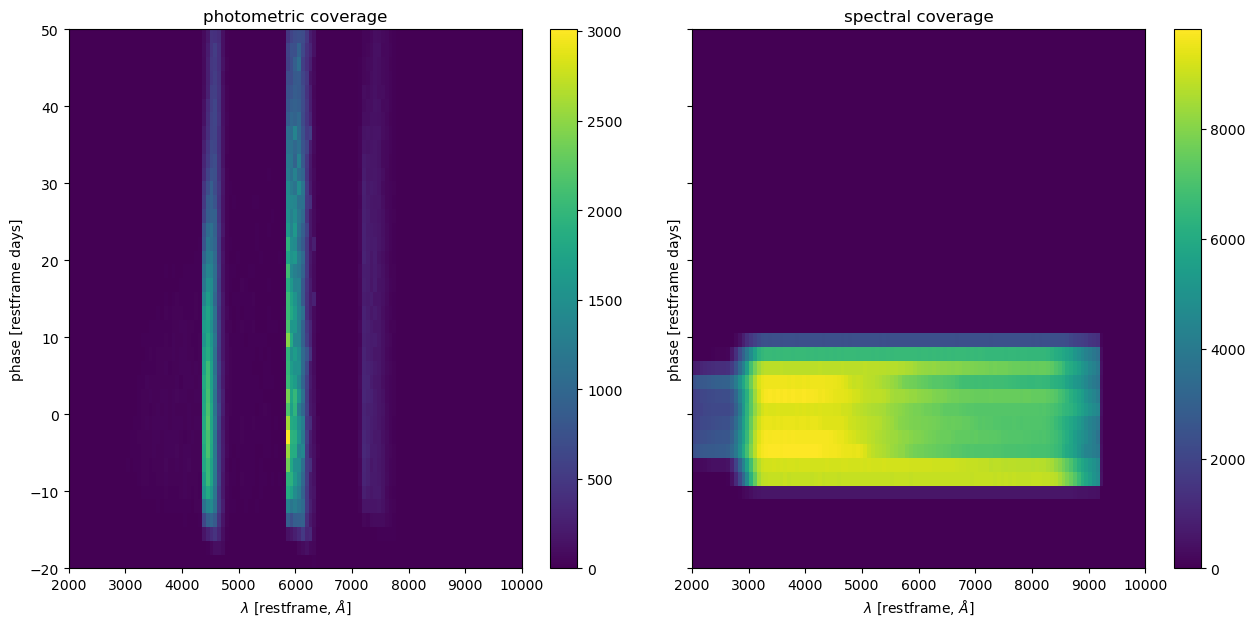

In [40]:
tds.plot_coverage()

In [13]:
import os
result_path = '/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/Tgrids/pets_uchuu_nacl/'
os.makedirs(result_path, exist_ok=True)


In [75]:
from nacl.tools import NaClTrainer

In [76]:
trainer = NaClTrainer('./data/tds_antoine', './outdir/')

2025-02-17 05:09:55,542 INFO loading lemaitre filterlib from /global/homes/a/agillesl/.cache/bbf/lemaitre_flib.default.0b8479e36fca60c99e76ea84d98cbe0c7383608814cddfaef21626fdf668b5c5.pkl
2025-02-17 05:09:56,314 INFO indexing light curves
2025-02-17 05:09:57,028 INFO indexing spectra
2025-02-17 05:09:57,029 WARNING _index_spectra: no spectra no index - pass
2025-02-17 05:09:57,033 INFO default regular grid in wavelength
2025-02-17 05:09:57,034 INFO user provided grid in phase
2025-02-17 05:09:57,048 INFO initializing lightcurve eval unit
/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
2025-02-17 05:10:15,683 INFO initializing spectrum eval unit


AttributeError: 'TrainingDataset' object has no attribute 'spec_db'

In [ ]:
trainer.clean()

In [ ]:
trainer.fit_lc()

In [ ]:
trainer_init = TrainSALT2Like(tds,
                      variance_model=None,
                      calib_variance=None,
                      color_scatter=False,
                      dust_extinction=DustExtinction().CCM89_dust())

pars_0 = trainer_init.log[0].pars
pars_true = pars_0.copy()
pars_true['tmax'] = -35 + pars_true['tmax'].full

# Création de la grille T_grid
T_grid = np.concatenate([np.arange(0, 30, 0.5),
                 np.arange(30, 40, 0.1),
                 np.arange(40, 70.5, 0.5)])

# Configuration du modèle
trainer = TrainSALT2Like(tds, variance_model=None, calib_variance=None, color_scatter=False)
trainer.mu_reg = 0
trainer.mu_cons = 0
full_pars_blocks = ['M0', 'M1', 'CL', 'X0', 'X1', 'c', 'tmax']
fixed_pars = ['M0', 'M1', 'CL', 'tmax']

# Initialisation des résultats
ll = LogLikelihood(trainer.model)
f0 = FitResults(pars=ll.pars)
f0.ll = ll
f0.v = trainer.model(f0.pars)
f0.var_v = None
trainer.log.append(f0)

# Ajustement des paramètres initiaux
pars_init = pars_0
pars_init['tmax'] = dt + pars_true['tmax'].full

# Ajustement du modèle
f1 = trainer.fit(fix=fixed_pars,
         fit_variance_model=False,
         force_spec_recalibration=False,
         p_init=pars_init,
         max_iter=25)
trainer.log.append(f1)

# Récupérer les résultats de l'ajustement
pars = trainer.log[-1].pars
v = trainer.log[-1].v

# Calcul des résidus et du chi2
res = tds.lc_data.flux - v
chi2_full = (res / tds.lc_data.fluxerr) ** 2
chi2_per_sn = np.bincount(tds.lc_data.sn_index, weights=chi2_full)[tds.sn_data.sn_index]

# Collecte des paramètres
t0 = pars_init['tmax'].full[tds.sn_data.sn_index]
x0 = pars['X0'].full[tds.sn_data.sn_index]
x1 = pars['X1'].full[tds.sn_data.sn_index]
c = pars['c'].full[tds.sn_data.sn_index]

# Calcul de la covariance
cov = trainer.log[-1].minz.get_cov_matrix()[0]
ii = [trainer.tds.sn_data.sn_index + i * len(trainer.tds.sn_data) for i in range(3)]
iii = np.hstack(ii)
cov_reindexed = cov[:, iii][iii]

# Extraire la diagonale pour obtenir les erreurs
variances = cov_reindexed.diagonal()
erreurs = np.sqrt(variances)

ex0 = erreurs[:len(t0)]
ex1 = erreurs[len(t0):len(t0) * 2]
ec = erreurs[len(t0) * 2:]

# Sauvegarde des résultats dans un fichier pickle
out = {
    'sn': tds.sn_data.nt.sn,
    'tmax': t0,
    'x0': x0,
    'exo': ex0,
    'x1': x1,
    'ex1': ex1,
    'c': c,
    'ec': ec,
    'chisq': chi2_per_sn
}

pickle.dump(out, open(f"{result_path}/result_{dt}.pkl", "wb"))


In [7]:
data_hsc, lc_hsc = load_from_pets("data/pets_hsc/Results/", survey="HSC")
data_snls, lc_snls = load_from_pets("data/pets_snls/Results/", survey="SNLS")

In [19]:
data_tot_pets = pandas.concat([data_snls, data_hsc])
data_tot_pets.set_index("name", inplace=True, drop=False)
lc_tot = pandas.concat([lc_snls, lc_hsc])

In [8]:
lc_ztf = pandas.read_csv("data/pets_uchuu/z0.2/mock_lc.csv", index_col=0).reset_index(drop=True)
lc_ztf.name = 'ZTF_' + lc_ztf.sn.astype(str)
lc_tot = pandas.concat([lc_ztf,
                        lc_snls,
                        lc_hsc
                       ])
data_ztf_pets = pandas.read_csv("data/pets_uchuu/z0.2/mock_sne.csv")
data_ztf_pets["survey"] = "ZTF"
data_tot_pets = pandas.concat([data_ztf_pets,
                               data_snls_pets,
                               data_hsc_pets
                         ])
data_tot_pets.valid = data_tot_pets.valid.astype(bool)
data_tot_pets.reset_index(drop=True, inplace=True)
data_tot_pets.name = data_tot_pets.survey + '_' + data_tot_pets.sn.astype(str)

In [9]:
data_snls_truth =load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_snls.pkl", survey="SNLS")
data_hsc_truth =load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_hsc.pkl", survey="HSC")
data_ztf_truth =load_from_skysurvey("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/SN_dataset/dataset_uchuu_0.2.pkl", survey="ZTF")

In [10]:
data_tot = pandas.concat([data_snls_truth, data_hsc_truth])
data_tot.set_index("name", inplace=True, drop=False)

In [11]:
data_tot['valid'] = data_tot_pets.valid

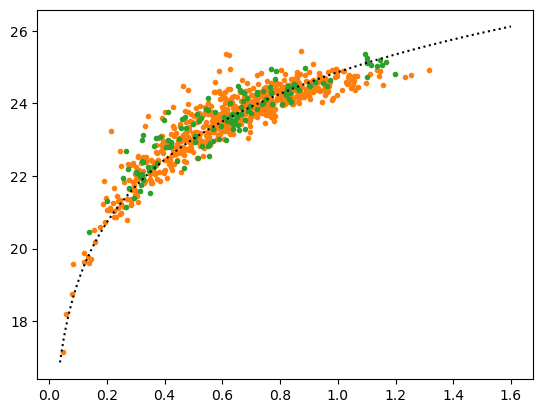

In [12]:
for survey in ["ZTF", "SNLS", "HSC"]:
    filt = (data_tot.survey==survey) & data_tot.valid
    plt.scatter(data_tot[filt].z,
                data_tot.magobs[filt],
                marker=".",
                color=survey_colors[survey],
                label=survey)
plt.plot(np.linspace(data_tot.z.min(), data_tot.z.max(), 1000),
         mag_Planck15(np.linspace(data_tot.z.min(), data_tot.z.max(), 1000)),
         linestyle=':',
         color='k')

In [33]:
source = sncosmo.SALT2Source(modeldir='data/SALT_snf/',
                             m0file = 'nacl_m0_test.dat',
                             m1file = 'nacl_m1_test.dat',
                             clfile = 'nacl_color_law_test.dat')
dust = sncosmo.CCM89Dust()
model= sncosmo.Model(source=source, effects=[dust],effect_names=['mw'],effect_frames=['obs'])


In [34]:
data_tot_pets['magobs'] = -2.5*np.log10(data_tot_pets.x0) + model.source.peakmag("bessellb", "ab")
data_tot_pets.set_index(data_tot_pets["name"], inplace=True)

/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


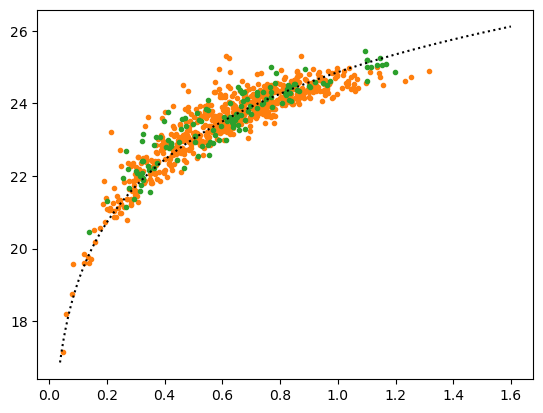

In [15]:
for survey in ["ZTF", "SNLS", "HSC"]:
    filt = (data_tot_pets.survey==survey) & data_tot_pets.valid
    plt.scatter(data_tot_pets[filt].z,
                data_tot_pets.magobs[filt],
                marker=".",
                color=survey_colors[survey],
                label=survey)
plt.plot(np.linspace(data_tot.z.min(), data_tot.z.max(), 1000),
         mag_Planck15(np.linspace(data_tot.z.min(), data_tot.z.max(), 1000)),
         linestyle=':',
         color='k')

In [40]:
results = [fit_sn(model, sn, lc_tot, data_tot_pets) for sn in tqdm(data_tot_pets.name)]

100%|██████████| 31905/31905 [01:56<00:00, 274.26it/s]


In [41]:
with open("outdir/salt_hsc_snls.pkl", "wb") as file:
    pickle.dump(results, file)

In [20]:
values = pandas.DataFrame([res.parameters[[0, 1, 2,3,4]] for res in results],
                 columns=["z", "t0", "x0","x1","c"],
                 index=lc_tot[lc_tot.valid==1].name.unique())

In [21]:
covs = {sn:res.covariance for res, sn in zip(results, lc_tot[lc_tot.valid==1].name.unique())}

In [22]:
with open("outdir/salt_full_0.2.pkl", "wb") as file:
    pickle.dump(values, file)
    pickle.dump(covs, file)

In [23]:
data_tot_pets.valid = [res.success for res in results]

In [38]:
with open("outdir/salt_full_modelcov_0.2.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [21]:
new_covs = {
    i: jnp.matmul(
        jnp.matmul(
            jnp.array(
                [
                    [-2.5 / (np.log(10) * values.loc[i, "x0"]), 0, 0],
                    [0, 1, 0],
                    [0, 0, 1],
                ]
            ),
            covs[i][1:,1:],
        ),
        jnp.array(
            [
                [-2.5 / (np.log(10) * values.loc[i, "x0"]), 0, 0],
                [0, 1, 0],
                [0, 0, 1],
            ]
        ),
    )
    for i in lc_tot[lc_tot.valid==1].name.unique()
}


In [22]:
values["magobs"] = -2.5*np.log10(values["x0"]) + model.source.peakmag("bessellb", "ab")

values['valid'] = data_tot_pets.valid

In [ ]:
lc_tot[lc_tot.valid==1].name.unique()

In [25]:
values

z            t0        x0        x1         c     magobs  \
ZTF_4      0.198376  58367.609994  0.000100  1.230470 -0.061938  20.504699   
ZTF_6      0.184227  58325.541561  0.000105  0.713306  0.077190  20.460387   
ZTF_7      0.079545  58426.819399  0.001013  1.691406 -0.113339  17.994389   
ZTF_9      0.173418  58900.989998  0.000122  2.443020 -0.182062  20.294882   
ZTF_10     0.085039  59008.744155  0.000694  0.126484 -0.070728  18.405522   
...             ...           ...       ...       ...       ...        ...   
HSC_22407  0.315150  57815.941269  0.000025  0.644089  0.065693  22.000902   
HSC_22549  0.316450  58844.744363  0.000032  0.103272 -0.054334  21.757035   
HSC_22721  0.628850  57803.231630  0.000006  0.786956 -0.011164  23.511978   
HSC_23549  0.961750  57819.066972  0.000003 -0.398432 -0.148208  24.492863   
HSC_23559  0.642150  57730.906831  0.000006  0.658632 -0.035672  23.521000   

          valid    err_t0        err_x0    err_x1     err_c  err_magobs  \
ZTF_4       NaN  0.005355  5.676415e-06  1.615273  0.058458    0.061413   
ZTF_6       NaN  0.595232  4.784356e-06  0.656843  0.047270    0.049692   
ZTF_7       NaN  0.313750  2.993580e-05  0.210474  0.028935    0.032081   
ZTF_9       NaN  0.003048  1.238914e-05  2.859376  0.095091    0.110484   
ZTF_10      NaN  0.050299  2.022713e-05  0.062660  0.025473    0.031655   
...         ...       ...           ...       ...       ...         ...   
HSC_22407  True  0.368272  1.030041e-06  0.390281  0.038954    0.044210   
HSC_22549  True  0.412021  1.402824e-06  0.203180  0.032593    0.048097   
HSC_22721  True  0.720193  3.787091e-07  0.599869  0.047638    0.065374   
HSC_23549  True  0.801363  1.285431e-07  0.941633  0.049911    0.054764   
HSC_23559  True  0.343742  1.396862e-06  1.294980  0.084850    0.243141   

                  mu    err_mu  
ZTF_4      20.872070  0.269228  
ZTF_6      20.317102  0.154103  
ZTF_7      18.588204  0.074724  
ZTF_9      21.210399  0.533749  
ZTF_10     18.646022  0.057498  
...              ...       ...  
HSC_22407  21.884142  0.059372  
HSC_22549  21.942645  0.061085  
HSC_22721  23.657317  0.119034  
HSC_23549  24.903937  0.182981  
HSC_23559  23.725577  0.194207  

[28808 rows x 14 columns]

In [29]:
values["err_t0"] = [np.sqrt(covs[i][0,0]) for i in values.index]
values["err_x0"] = [np.sqrt(covs[i][1,1]) for i in values.index]
values["err_x1"] = [np.sqrt(covs[i][2,2]) for i in values.index]
values["err_c"] = [np.sqrt(covs[i][3,3]) for i in values.index]
values["err_magobs"] = 2.5*values["err_x0"] / (np.log(10) * values["x0"])

In [35]:
values["mu"] = values.magobs + 0.14*values.x1 - 3.15*values.c
data_tot_pets["mu"] = data_tot_pets.magobs + 0.14*data_tot_pets.x1 - 3.15*data_tot_pets.c


In [36]:
plt.scatter(values[values.valid].z,
            values[values.valid].magobs + 0.14*values[values.valid].x1 - 3.15*values[values.valid].c,
            marker=".",
            label='SALT2.4')
plt.scatter(data_tot_pets[data_tot_pets.valid].zhel,
            data_tot_pets[data_tot_pets.valid].magobs + 0.14*data_tot_pets[data_tot_pets.valid].x1 - 3.15*data_tot_pets[data_tot_pets.valid].c,
            s=3,
            marker=".",
            label="Truth")
plt.legend()

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [33]:
mag_to_z = interp1d(mag_Planck15(np.linspace(1e-5, 0.3, 10000)),np.linspace(1e-5, 0.3, 10000))

In [34]:
data_tot_pets['err_magobs'] = 2.5*data_tot_pets.err_x0/(np.log(10) * data_tot_pets.x0)

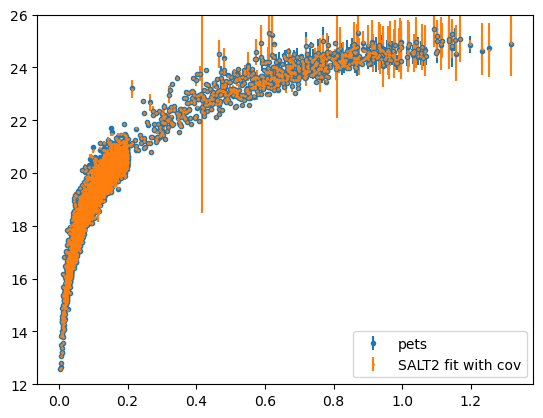

In [35]:
plt.errorbar(data_tot_pets[values.valid].zhel,
             data_tot_pets[values.valid]["magobs"],
             data_tot_pets[values.valid]["err_magobs"],
             linestyle='',
             marker='.',
             label='pets')

plt.errorbar(values[values.valid].z,
             values[values.valid].magobs,
             values[values.valid].err_magobs,
             linestyle='',
             markersize=2,
             marker='.',
             label='SALT2 fit with cov')
plt.ylim(12,26)
plt.legend()

In [36]:
mu_covs = {
    i: jnp.matmul(
        jnp.matmul(
            jnp.array(
                [
                    [1, 0.14, -3.15],
                    [0, 1, 0],
                    [0, 0, 1],
                ]
            ),
            new_covs[i],
        ),
        jnp.array(
            [
                [1, 0, 0],
                [0.14, 1, 0],
                [-3.15, 0, 1],
            ]
        ),
    )
    for i in values.index
}
values['mu'] = values.magobs + 0.14*values.x1 - 3.15*values.c
values['err_mu'] = jnp.sqrt(np.array([mu_covs[i][0,0] for i in values.index]))

In [37]:
data_tot_pets["mu"] = data_tot_pets.magobs + \
                        0.14*data_tot_pets.x1 - \
                        3.15*data_tot_pets.c

data_tot_pets["err_mu"] = np.sqrt(data_tot_pets['err_magobs']**2 + \
                        0.14*data_tot_pets['err_x1']**2 + \
                        3.15*data_tot_pets['err_c']**2)

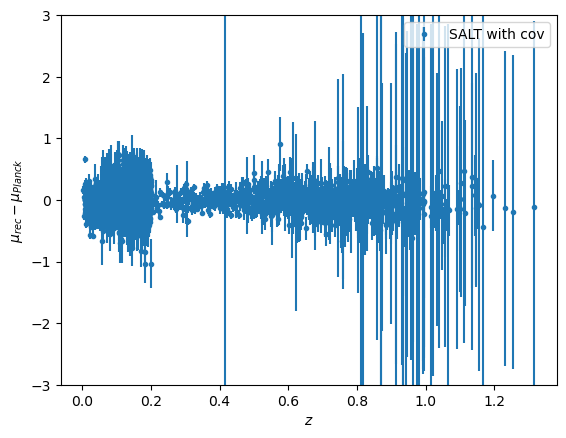

In [38]:
# plt.errorbar(data_tot_pets[values.valid].zhel,
#              data_tot_pets[values.valid].mu - mag_Planck15(data_tot_pets.zhel[values.valid]),
#              data_tot_pets[values.valid].err_mu,
#              linestyle='',
#              markersize=2,
#              marker='.',
#              label='PETS')

plt.errorbar(values[values.valid].z,
             values[values.valid].mu - mag_Planck15(values[values.valid].z),
             values[values.valid].err_mu,
             linestyle='',
             marker='.',
             label='SALT with cov')
plt.ylim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu_{rec} - \mu_{Planck}$")
plt.legend()

In [39]:
use_vpec = (values.valid) & (data_tot_pets.survey=='ZTF')
z_cosmo_pets = mag_to_z(values[use_vpec].mu)

In [40]:
errp_z_cosmo_pets = mag_to_z(values[use_vpec].mu + values[use_vpec].err_mu) - z_cosmo_pets
errm_z_cosmo_pets = z_cosmo_pets - mag_to_z(values[use_vpec].mu -\
                             values[use_vpec].err_mu)

In [41]:
z_cosmo=mag_to_z(data_tot[data_tot.survey=="ZTF"].magobs + 0.14*data_tot[data_tot.survey=="ZTF"].x1 - 3.15*data_tot[data_tot.survey=="ZTF"].c)

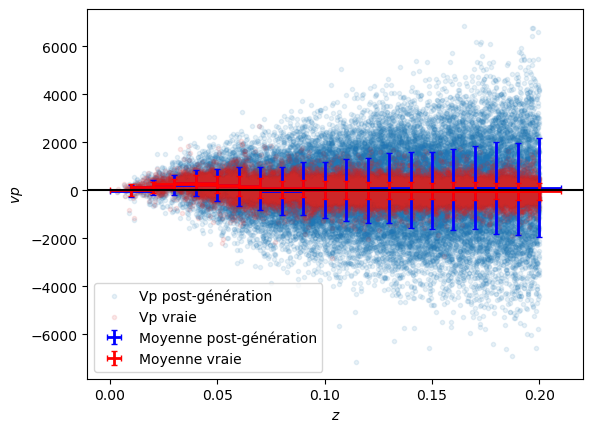

In [42]:
data_ztf = data_tot[data_tot.survey=="ZTF"]
pv = (data_ztf.z-z_cosmo)*c*1e-3/(1+z_cosmo)
true_pv = (data_ztf.z-data_ztf.z_cosmo)*c*1e-3/(1+data_ztf.z_cosmo)

z_max = 0.2
n_bins = 20
bounds = np.linspace(0.00, z_max, n_bins+1)
width = z_max/n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z< z_min + width) for z_min in bounds]

plt.scatter(data_ztf.z,
            pv,
            marker=".",
            alpha=0.1,
            label="Vp post-génération")
plt.scatter(data_ztf.z,
            true_pv,
            marker=".",
            color="tab:red",
            alpha=0.1,
            label="Vp vraie")

plt.errorbar(bounds+width,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width,
             linestyle='',
             color='blue',
             linewidth=2,
             capsize=2,
             label="Moyenne post-génération")

plt.errorbar(bounds+width,
             [true_pv[filt].mean() for filt in in_bins],
             yerr=[true_pv[filt].std() for filt in in_bins],
             xerr=width,
             linestyle='',
             color='red',
             linewidth=2,
             capsize=2,
             label="Moyenne vraie")

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color='k')

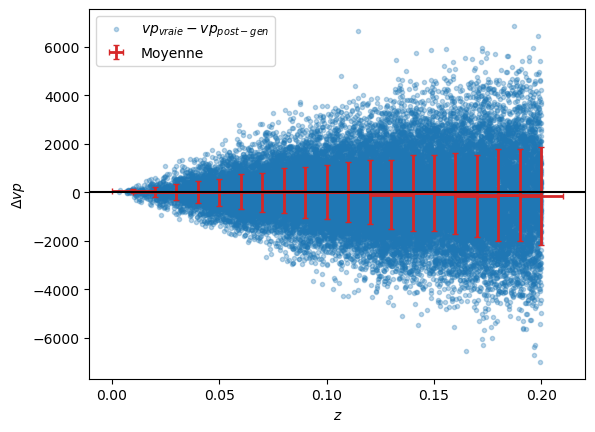

In [43]:
plt.scatter(data_ztf.z,
            true_pv - pv,
            marker=".",
            alpha=0.3,
            label="$vp_{vraie} - vp_{post-gen}$")

plt.errorbar(bounds + width,
             [(true_pv - pv)[filt].mean() for filt in in_bins],
             yerr=[(true_pv - pv)[filt].std() for filt in in_bins],
             xerr=width,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()

plt.axhline(0, color='k')

In [44]:
np.array([errp_z_cosmo_pets, errm_z_cosmo_pets])*c.value*1e-3

array([[ 628.65739786, 2090.38844884,  346.32485744, ...,  876.32789377,
         156.39131104,  900.40410918],
       [ 613.81547204, 2004.62833661,  338.33230384, ...,  852.37622116,
         151.77936161,  874.91152835]])

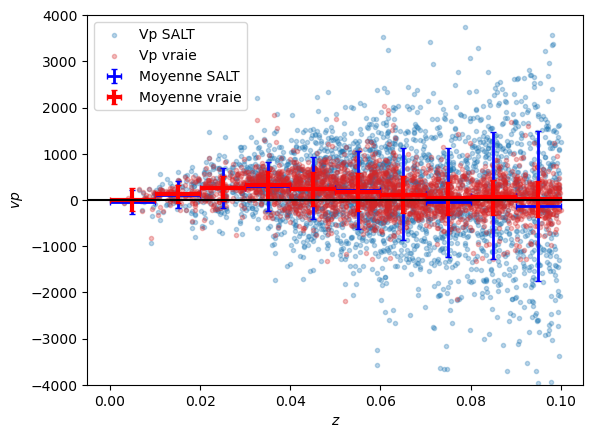

In [46]:
z_max = 0.2
n_bins = 20
bounds = np.linspace(0.00, z_max, n_bins+1)
width = z_max/n_bins

data_used = data_ztf[(values[data_tot_pets.survey=="ZTF"].valid) & (data_ztf.z < 0.1)]

in_bins = [(data_used.z > z_min) & (data_used.z< z_min + width) for z_min in bounds]

pets_pv = (data_used.z - z_cosmo_pets[values[use_vpec].z < 0.1])*c*1e-3/(1+z_cosmo_pets[values[use_vpec].z < 0.1])
true_pv = (data_used.z - data_used.z_cosmo)*c*1e-3/(1+data_used.z_cosmo)

plt.scatter(data_used.z,
            pets_pv,
            marker=".",
            alpha=0.3,
            label="Vp SALT")
plt.scatter(data_used.z,
            true_pv,
            marker=".",
            color="tab:red",
            alpha=0.3,
            label="Vp vraie")

plt.errorbar(bounds + width/2,
             [pets_pv[filt].mean() for filt in in_bins],
             yerr=[pets_pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             capsize=2,
             label="Moyenne SALT")

plt.errorbar(bounds + width/2,
             [true_pv[filt].mean() for filt in in_bins],
             yerr=[true_pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='red',
             linewidth=3,
             capsize=2,
             label="Moyenne vraie")


plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.ylim(-4000, 4000)
plt.axhline(0, color='k')

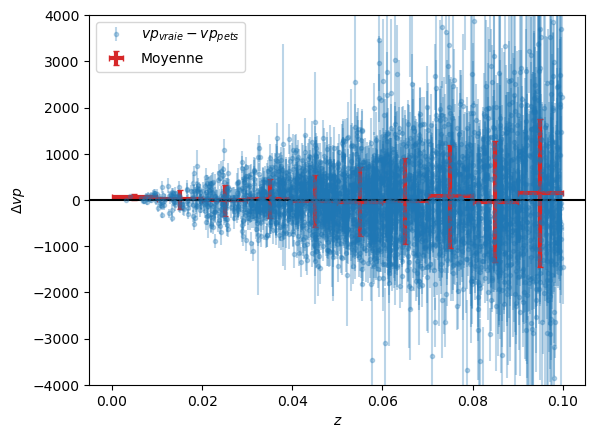

In [48]:
plt.errorbar(data_used.z,
            true_pv - pets_pv,
            np.array([errp_z_cosmo_pets[values[use_vpec].z < 0.1], errm_z_cosmo_pets[values[use_vpec].z < 0.1]])*c.value*1e-3,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{pets}$")
plt.errorbar(bounds + width/2,
             [(true_pv - pets_pv)[filt].mean() for filt in in_bins],
             yerr=[(true_pv - pets_pv)[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='tab:red',
             linewidth=3,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [49]:
np.mean(true_pv - pets_pv), np.std(true_pv - pets_pv)

(13.447745915883255, 979.5745445765999)

(-100.0, 100.0)

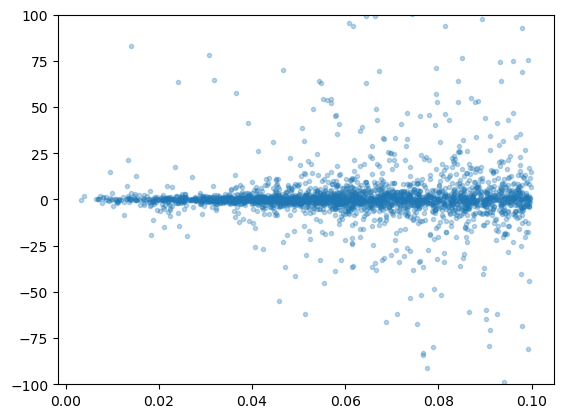

In [50]:
plt.errorbar(data_used.z,
            (true_pv - pets_pv)/true_pv,
            marker=".",
            linestyle='',
            alpha=0.3)
plt.ylim(-100,100)

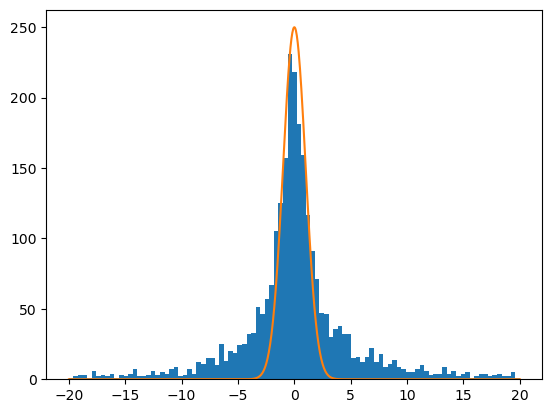

In [51]:
_=plt.hist((true_pv - pets_pv)/true_pv, bins=np.linspace(-20, 20, 100))
plt.plot(np.linspace(-20,20,1000), 250*np.exp(-np.linspace(-20,20,1000)**2/2))

In [53]:
with open("outdir/salt_full_modelcov_0.2.pkl", "wb") as file:
    pickle.dump(values, file)
    pickle.dump(covs, file)

In [482]:
filt = (values.c < 0.3) &\
       (values.err_x1 + np.abs(values.x1) < 5) &\
       (values.err_c < .05) &\
       (values.err_ )
sum(filt)

17208

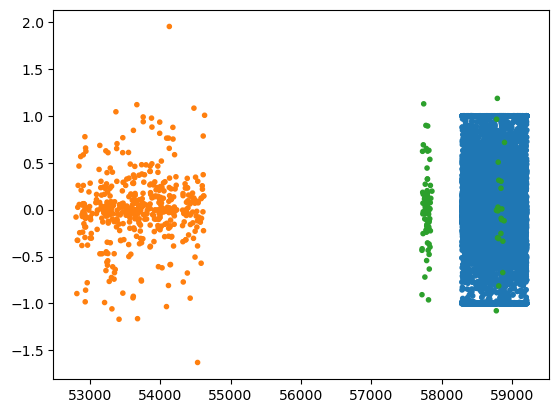

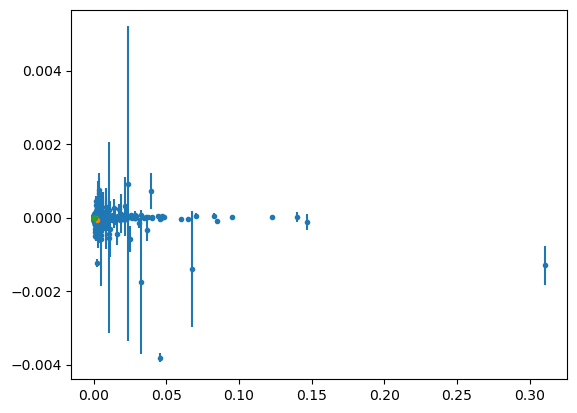

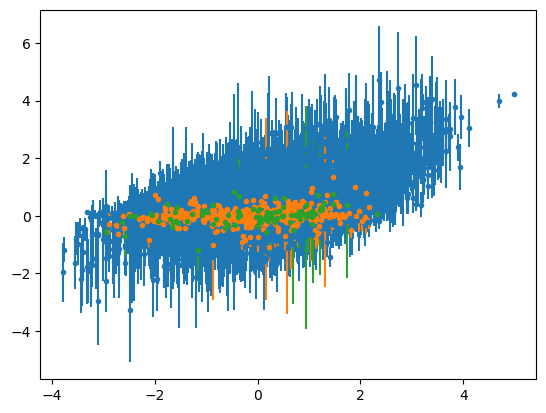

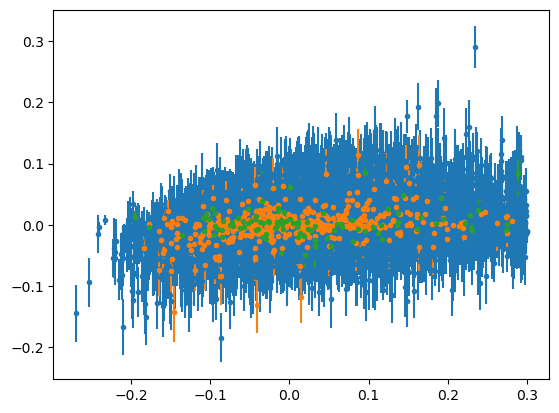

In [549]:
plt.scatter(values[filt].t0,
            values[filt].t0 - data_tot[filt].t0,
            c=[survey_colors[s] for s in data_tot[filt].survey],
            marker='.')
plt.figure()
for s in survey_colors.keys():
    plt.errorbar(values[filt & (data_tot.survey==s)].x0,
                values[filt & (data_tot.survey==s)].x0 - data_tot[filt & (data_tot.survey==s)].x0,
                values[filt & (data_tot.survey==s)].err_x0,
                c=survey_colors[s],
                linestyle='',
                marker='.')

plt.figure()
for s in survey_colors.keys():

    plt.errorbar(values[filt & (data_tot.survey==s)].x1,
                values[filt & (data_tot.survey==s)].x1 - data_tot[filt & (data_tot.survey==s)].x1,
                values[filt & (data_tot.survey==s)].err_x1,
                c=survey_colors[s],
                linestyle='',
                marker='.')
plt.figure()
for s in survey_colors.keys():
    plt.errorbar(values[filt & (data_tot.survey==s)].c,
                values[filt & (data_tot.survey==s)].c - data_tot[filt & (data_tot.survey==s)].c,
                values[filt & (data_tot.survey==s)].err_c,
                c=survey_colors[s],
                linestyle='',
                marker='.')

### Fit with nacl

In [7]:
from nacl.train import TrainSALT2Like

from nacl.dataset import TrainingDataset
from nacl.models.salt2 import SALT2Like
from nacl.specutils import clean_and_project_spectra
from nacl.models.salt2 import DustExtinction

2025-01-24 06:28:37,788 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-01-24 06:28:37,790 INFO sparse_dot_mkl found. Building hessian should be faster.


In [8]:
lc_ztf = pandas.read_csv("data/pets_uchuu/Results/mock_lc.csv", index_col=0).reset_index(drop=True)
lc_snls = pandas.read_csv("data/pets_snls/Results/mock_lc.csv", index_col=0)
lc_snls.sn += 10000
lc_snls.lc += 10000
lc_tot = pandas.concat([lc_ztf,
                        lc_snls
                       ])
lc_tot.valid = lc_tot.valid.astype(bool)

data_ztf = pandas.read_csv("data/pets_uchuu/Results/mock_sne.csv", index_col=0).reset_index(drop=True)
data_snls = pandas.read_csv("data/pets_snls/Results/mock_sne.csv")
data_snls.index += 10000
data_snls.sn += 10000
data_snls.survey='SNLS'
data_tot = pandas.concat([data_ztf,
                          data_snls
                         ])
data_tot.valid = data_tot.valid.astype(bool)

spectra_ztf = pandas.read_csv('data/Mock_Uchuu_sp_2.csv', index_col=0).reset_index(drop=True)
spectra_snls = pandas.read_csv('data/Mock_snls_sp.csv', index_col=0).reset_index(drop=True)
spectra_snls.spec += 10000
spectra_snls.sn += 10000
spectra_tot = pandas.concat([spectra_ztf,
                             spectra_snls,
                            ])
spectra_tot.valid = spectra_tot.valid.astype(bool)

In [9]:
def make_tds_from_pets(sne_data, lc_data, sp_data, sigma_x1_lim=.1, sigam_c_lim=0.02, basis_knots=[127, 20], wl_range=(2000., 11000.)):
    # sne_data["valid"] = sne_data["valid"] & (sne_data["err_x1"] < sigma_x1_lim) & (sne_data["err_c"] < sigam_c_lim)
    sne_data.rename(columns={'t0':'tmax', 'zhel':'z'}, inplace=True)

    lc_data.set_index([lc_data.sn, lc_data.index], inplace=True)
    lc_data.index.names= [None, None]
    lc_data['x'] = 0.
    lc_data['y'] = 0.
    lc_data['sensor_id'] = 0
    lc_data.rename(columns={"time":"mjd"}, inplace=True)
    lc_data.index.names = [None, None]

    sp_data['i_basis'] = 0
    sp_data.rename(columns={"snid":"sn", "time":"mjd", 'flux_true':'fluxtrue'}, inplace=True)
    
    for sn in tqdm(sne_data.sn[~sne_data.valid], desc="Clearing LC and spectra according to PeTs"):
        sp_data.loc[sp_data['sn']==sn, "valid"] = False
        lc_data.loc[lc_data['sn']==sn, "valid"] = False

    # Clean points corresponding to invalid SN

    tds = TrainingDataset(sne=sne_data.to_records(),
                          lc_data=lc_data.to_records(),
                          spec_data=sp_data.to_records(),
                          filterlib=filterlib)
    SALT2Like.flag_out_of_range_datapoints(tds,
                                           wl_range=wl_range,
                                           basis_knots=basis_knots,
                                           compress=True)
    model = SALT2Like(tds,
                      wl_range=wl_range,
                      basis_knots=basis_knots,
                      dust_extinction_model=DustExtinction().CCM89_dust(),
                     )
    # Project spectra onto spline basis
    projected_spectra, in_error = clean_and_project_spectra(tds, model.basis.bx)
    
    return TrainingDataset(tds.sn_data.nt, lc_data=tds.lc_data.nt,
                           spec_data=np.rec.array(np.hstack(projected_spectra)),
                           basis=model.basis.bx,
                           filterlib=filterlib,
                           )

In [10]:
tds = make_tds_from_pets(data_tot, lc_tot, spectra_tot, basis_knots=[127,20])

Clearing LC and spectra according to PeTs: 100%|██████████| 7929/7929 [00:14<00:00, 552.89it/s]
2025-01-24 06:28:56,872 INFO indexing light curves
2025-01-24 06:28:57,126 INFO indexing spectra
2025-01-24 06:28:59,259 INFO default regular grid in wavelength
2025-01-24 06:28:59,260 INFO default regular grid in phase
2025-01-24 06:29:00,267 WARNING 51216 lc data points outside the model definition range
2025-01-24 06:29:00,836 INFO indexing light curves
2025-01-24 06:29:00,976 INFO indexing spectra
2025-01-24 06:29:03,087 INFO default regular grid in wavelength
2025-01-24 06:29:03,088 INFO default regular grid in phase
2025-01-24 06:29:03,122 INFO initializing lightcurve eval unit
/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/dust_extinction/helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
2025-01-24 06:29:04,719 INFO initializing spectrum eval unit
2025-01-24 06:29:06,347 INFO user provided grid in wavelength
20

In [11]:
tds.to_parquet('tds_antoine', './data/')

In [ ]:
tds.plot_sample()

In [ ]:
tds = TrainingDataset.read_parquet('tds_antoine', './data/', filterlib=filterlib)

In [ ]:
with open("outdir/SN_Uchuu.pkl", "rb") as file:
    data_ztf_truth = pickle.load(file).rename(columns={'t0':'tmax'})

data_ztf_truth['sn'] = data_ztf.index
data_ztf_truth['survey'] = "ZTF"

    
with open("outdir/dataset_snls.pkl", "rb") as file:
    data_snls_truth = pickle.load(file).rename(columns={'t0':'tmax'})
data_snls_truth.index += 10000
data_snls_truth['sn'] = data_snls_truth.index
data_snls_truth['survey']='SNLS'

data_tot_truth = pandas.concat([data_ztf_truth, data_snls_truth]).dropna(axis=1)
float32_cols = list(data_tot_truth.select_dtypes(include='float32'))
data_tot_truth[float32_cols] = data_tot_truth[float32_cols].astype('float64')

data_tot_truth["valid"] = [sn in data_tot[data_tot.valid].sn for sn in data_tot_truth.sn]

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='False'

In [ ]:
trainer = TrainSALT2Like(tds,
                         # variance_model='sn_local_snake'
                         variance_model='simple_snake',
                        )

In [ ]:
trainer.mu_cons = 1e6

In [ ]:
from joblib import Parallel, delayed

In [ ]:
def run(mu_reg):
    trainer = TrainSALT2Like(tds,
                         # variance_model='sn_local_snake'
                         variance_model='simple_snake',
                        )
    trainer.mu_reg = mu_reg
    trainer.train_salt2_model_test()
    trainer.save(f"/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/test_reg_{mu_reg}.pkl")

In [ ]:
for mu_reg in np.logspace(-1, 1, 3):
    run(mu_reg)

In [ ]:
trainer.train_salt2_model_test()

In [ ]:
trainer.save('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/test_reg_1e2.pkl')

In [ ]:
trainer = TrainSALT2Like.load('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/test.pkl')

In [ ]:
pars_trained = trainer.log[-1].pars
v_trained = trainer.log[-1].v

In [ ]:
lc_nacl = pandas.DataFrame(trainer.tds.lc_data.nt, index=trainer.tds.lc_data.nt["sn"])

In [ ]:
spec_nacl = pandas.DataFrame(trainer.tds.spec_data.nt).drop(columns='index')

In [ ]:
data_nacl = pandas.DataFrame(trainer.tds.sn_data.nt,
                             index = trainer.tds.sn_data.nt["sn"]).drop(columns=['index', 'err_c', 'err_tmax', 'err_x0', 'err_x1'])

# pars_trained = f2.pars
data_nacl["tmax"] = pars_trained["tmax"]._pars[trainer.tds.sn_data.sn_index]
data_nacl["x0"] = pars_trained["X0"]._pars[trainer.tds.sn_data.sn_index]
data_nacl["x1"] = pars_trained["X1"]._pars[trainer.tds.sn_data.sn_index]
data_nacl["c"] = pars_trained["c"]._pars[trainer.tds.sn_data.sn_index]

In [ ]:
nacl_flux_lc = v_trained[:lc_nacl.shape[0]]

In [ ]:
lc_nacl.set_index([lc_nacl.level_0, lc_nacl.level_1], inplace=True)

In [ ]:
pars_init = trainer.log[1].pars
v_init = trainer.log[1].v
nacl_flux_lc_init = v_init[:lc_nacl.shape[0]]

In [ ]:
plot_lc_index(240, lc_nacl)
for band, c in zip(["ztfr", "ztfg", "ztfi"], ["tab:red", "tab:green", "yellow"]):
    filt = (lc_nacl.sn==240) & (lc_nacl.band==band)
    plt.scatter(lc_nacl.mjd[filt],
                nacl_flux_lc[filt] * np.power(10, -0.4*(trainer.tds.lc_data.zp[filt] - 25)),
                color=c,
                label=f'NaCl {band}')
plt.xlabel("mjd")
plt.ylabel("flux (zp=25)")
for band, c in zip(["ztfr", "ztfg", "ztfi"], ["tab:red", "tab:green", "yellow"]):
    filt = (lc_nacl.sn==240) & (lc_nacl.band==band)
    plt.scatter(lc_nacl.mjd[filt],
                nacl_flux_lc_init[filt] * np.power(10, -0.4*(trainer.tds.lc_data.zp[filt] - 25)),
                color=c,
                label=f'NaCl {band} init',
                marker="+")

plt.legend()

In [ ]:
def plot_res(data, data_truth, col, label, unit=None, log=False, linthresh=1e-3, split_survey=False):
    fig, axs = plt.subplots(ncols=2, nrows=2, sharex='col', sharey='row', figsize=(10,7))
    delta = data_truth[col] - data[col] 

    if split_survey:
        surveys=np.unique(data.survey)
        for s in surveys:
            filt=data.survey==s
            axs[0,0].errorbar(data_truth[filt][col], data[filt][col],
                              yerr = data[filt]["err_"+col] if "err_"+col in data.columns else None,
                              linestyle="", marker=".", label=s)
            axs[1,0].errorbar(data_truth[filt][col], delta[filt],
                              yerr = data[filt]["err_"+col] if "err_"+col in data.columns else None,
                              linestyle="", marker=".", label=s)
            axs[0,0].legend()
    else:
        axs[0,0].errorbar(data_truth[col], data[col],
                          yerr = data["err_"+col] if "err_"+col in data.columns else None,
                          linestyle="", marker=".")
        axs[1,0].errorbar(data_truth[col], delta,
                          yerr = data["err_"+col] if "err_"+col in data.columns else None,
                          linestyle="", marker=".")
    
    axs[0,0].plot([data_truth[col].min() - 1e-3, data_truth[col].max() + 1e-3], [data_truth[col].min() - 1e-3, data_truth[col].max() + 1e-3], linestyle=':', color='r')
    axs[1,0].axhline(0, linestyle=':', color='r')

    if log:
        axs[0,0].loglog()
        axs[1,0].semilogx()
        axs[1,0].set_yscale("symlog", linthresh=linthresh)
        
        l_bins = np.logspace(np.log10(np.min(np.abs(delta))) - 1e-10, np.log10(np.max(np.abs(delta))) + 1e-10, 40)
        if split_survey:
            axs[1,1].hist([delta[data.survey==s] for s in surveys], bins=[*(-l_bins[::-1]), *l_bins],
                          orientation='horizontal', stacked=True, label=surveys)
        else:
            axs[1,1].hist(delta, bins=[*(-l_bins[::-1]), *l_bins], orientation='horizontal')

    else:
        if split_survey:
            axs[1,1].hist([delta[data.survey==s] for s in surveys], bins=80,
                          orientation='horizontal', stacked=True, label=surveys)
        else:
            axs[1,1].hist(delta, bins=80, orientation='horizontal')
        
    axs[1,1].set_xlabel("Count")
    mean, std = delta.mean(), delta.std()
    axs[1,1].axhline(mean, linestyle='--', color='tab:purple', label=f'Mean : {mean:.3e}')
    axs[1,1].axhline(mean-std, linestyle=':', color='tab:purple', label=f'Std : {std:.3e}')
    axs[1,1].axhline(mean+std, linestyle=':', color='tab:purple')
    axs[1,1].legend()

    if unit:
        axs[0,0].set_xlabel(label.lower() + '$_{Truth}$ (' + unit + ')')
        axs[0,0].set_ylabel(label + ' (' + unit + ')')
        axs[1,0].set_xlabel(label.lower() + '$_{Truth}$ (' + unit + ')')
        axs[1,0].set_ylabel(label.lower() + '$_{Truth} - $' + ' (' + unit + ')')
    else:
        axs[0,0].set_xlabel(label.lower() + '$_{Truth}$')
        axs[0,0].set_ylabel(label)
        axs[1,0].set_xlabel(label.lower() + '$_{Truth}$')
        axs[1,0].set_ylabel(label.lower() + '$_{Truth} - $' + label)

    fig.delaxes(axs[0,1])


In [ ]:
plot_res(data_nacl, data_tot_truth[data_tot_truth.valid], "x0", "$X_0$", log=True, linthresh=1e-8, split_survey=True)
# plt.savefig("../figures/nacl_cooking_recipe/X0.png")
plot_res(data_nacl, data_tot_truth[data_tot_truth.valid], "x1", "$X_1$", split_survey=True)
# plt.savefig("../figures/nacl_cooking_recipe/X1.png")
plot_res(data_nacl, data_tot_truth[data_tot_truth.valid], "c", "$C$", split_survey=True)
# plt.savefig("../figures/nacl_cooking_recipe/C.png")
plot_res(data_nacl, data_tot_truth[data_tot_truth.valid], "tmax", "$T_{max}$", split_survey=True)
# plt.savefig("../figures/nacl_cooking_recipe/T_max.png")

In [ ]:
plot_res(data_tot[data_tot.valid], data_tot_truth, "x0", "$X_0$", log=True, linthresh=1e-8, split_survey=True)
plt.savefig("../figures/nacl_cooking_recipe/pets_X0.png")
plot_res(data_tot[data_tot.valid], data_tot_truth, "x1", "$X_1$", split_survey=True)
plt.savefig("../figures/nacl_cooking_recipe/pets_X1.png")
plot_res(data_tot[data_tot.valid], data_tot_truth, "c", "$C$", split_survey=True)
plt.savefig("../figures/nacl_cooking_recipe/pets_C.png")
plot_res(data_tot[data_tot.valid], data_tot_truth, "tmax", "$T_{max}$", split_survey=True)
plt.savefig("../figures/nacl_cooking_recipe/pets_T_max.png")

In [ ]:
plt.hist((data_tot[data_tot.valid].x0 - data_tot_truth.x0)/data_tot[data_tot.valid].err_x0, bins=50)
plt.plot(np.linspace(-5,5,1000), 350*np.exp(-np.linspace(-5,5,1000)**2/np.sqrt(2)))

In [ ]:
_=plt.hist((data_tot[data_tot.valid]['x0'])/data_tot_truth['x0'], bins=100)
plt.xlabel("$x_0(nacl)/x_0(true)$")

mean, std = np.mean((data_tot[data_tot.valid]['x0'])/data_tot_truth['x0']), np.std((data_tot[data_tot.valid]['x0'])/data_tot_truth['x0'])
plt.axvline(mean, color="r", label="Mean")
plt.axvline(mean+std, color="r", linestyle=":", label="Std")
plt.axvline(mean-std, color="r", linestyle=":")
plt.legend()
print("ratio mean:", mean)
print("ratio std:", std)

In [ ]:
_=plt.scatter(data_nacl["z"], (data_nacl['x0'])/data_tot_truth[data_tot_truth.valid]['x0'],
              color=["tab:blue" if surv=="ZTF" else "tab:orange" for surv in data_nacl.survey],
              marker=".", alpha=0.3)

plt.axhline(1, color="k", linestyle=":")

is_ztf = data_tot_truth.valid & (data_tot_truth.survey=="ZTF")
is_snls = data_tot_truth.valid & (data_tot_truth.survey=="SNLS")

mean_snls = np.mean((data_nacl[data_nacl.survey=='SNLS']['x0'])/data_tot_truth[is_snls]['x0'])
std_snls = np.std((data_nacl[data_nacl.survey=='SNLS']['x0'])/data_tot_truth[is_snls]['x0'])

plt.axhline(mean_snls, color="tab:red", label=f"Mean SNLS {mean_snls:.3g}")
plt.axhline(mean_snls+std_snls, color="tab:red", linestyle=":", label=f"Std SNLS {std_snls:.2g}")
plt.axhline(mean_snls-std_snls, color="tab:red", linestyle=":")
plt.legend()

mean_ztf = np.mean((data_nacl[data_nacl.survey=='ZTF']['x0'])/data_tot_truth[is_ztf]['x0'])
std_ztf = np.std((data_nacl[data_nacl.survey=='ZTF']['x0'])/data_tot_truth[is_ztf]['x0'])

plt.axhline(mean_ztf, color="tab:green", label=f"Mean ZTF {mean_ztf:.3g}")
plt.axhline(mean_ztf+std_ztf, color="tab:green", linestyle=":", label=f"Std ZTF {std_ztf:.2g}")
plt.axhline(mean_ztf-std_ztf, color="tab:green", linestyle=":")
plt.legend()

plt.ylabel("$x_0(nacl)/x_0(true)$")
plt.xlabel("$z$")


In [ ]:
_=plt.scatter(data_nacl[data_nacl.survey=='ZTF']["mwebv"], (data_nacl[data_nacl.survey=='ZTF']['x0'])/data_tot_truth[data_tot_truth.valid & (data_nacl.survey=='ZTF')]['x0'],
              color="tab:blue",
              marker=".", alpha=0.3,
              label='ZTF')
_=plt.scatter(data_nacl[data_nacl.survey=='SNLS']["mwebv"], (data_nacl[data_nacl.survey=='SNLS']['x0'])/data_tot_truth[data_tot_truth.valid & (data_nacl.survey=='SNLS')]['x0'],
              color="tab:orange",
              marker=".", alpha=0.3,
              label='SNLS')

plt.axhline(1, color="k", linestyle=":")
plt.legend()

plt.ylabel("$x_0(nacl)/x_0(true)$")
plt.xlabel("$mwebv$")


In [ ]:
data_nacl[(data_nacl['x0'])/data_tot_truth[data_tot_truth.valid]['x0'] > 1.2]

In [ ]:
trainer.plot_lc(826, numfit=[0,-1])
# plt.savefig("../figures/nacl_cooking_recipe/ZTF_lc.png")

In [ ]:
trainer.train_salt2_model()
trainer.save('outdir/nacl_Uchuu_snls_new_dusts.pkl')
# trainer.save('outdir/nacl_Uchuu_snls_reg_1e3.pkl')

In [ ]:
pars_init = trainer.model.init_pars()
pars_trained = trainer.log[-1].pars

wl = np.linspace(2000, 11000, 3000)
ph = np.linspace(50, -20, 3000)
WL, PH = np.meshgrid(wl, ph)
J = trainer.model.basis.eval(WL.ravel(), PH.ravel())
M0 = (J @ pars_init['M0'].full).reshape((len(wl), len(ph)))
M1 = (J @ pars_init['M1'].full).reshape((len(wl), len(ph)))

M0_trained = (J @ pars_trained['M0'].full).reshape((len(wl), len(ph)))
M1_trained = (J @ pars_trained['M1'].full).reshape((len(wl), len(ph)))

In [ ]:
import sncosmo

source = sncosmo.SALT2Source(modeldir='./data/SALT_snf', m0file='nacl_m0_test.dat', m1file='nacl_m1_test.dat', clfile='nacl_color_law_test.dat')

model_sncosmo = sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
sn_cosmo_M0 = source._model['M0'](ph, wl) / source._SCALE_FACTOR
sn_cosmo_M1 = source._model['M1'](ph, wl) / source._SCALE_FACTOR


In [ ]:
import matplotlib as mpl

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12.8, 4.8])

im = axs[0].imshow(M0, extent=[2000, 11000, -20, 50], aspect='auto', origin='upper')
plt.colorbar(im, ax=axs[0])
axs[0].set_title("$M_0^{SALT2.4}$")

im = axs[1].imshow(M0_trained, extent=[2000, 11000, -20, 50],
                   vmin=np.min(M0), vmax=np.max(M0),
                   aspect='auto', origin='upper')
plt.colorbar(im, ax=axs[1])
axs[1].set_title("$M_0^{NaCl}$")

im = axs[2].imshow(M0 - M0_trained, extent=[2000, 11000, -20, 50],
                   vmin=-.05, vmax=.05,
                   aspect='auto', origin='upper')
plt.colorbar(im, ax=axs[2])
axs[2].set_title("$M_0^{SALT2.4} - M_0^{NaCl}$")

for i in range(3):
    # axs[i].set_xlim(2500,9000)
    # axs[i].set_ylim(-10,+40)
    axs[i].set_ylabel("Phase (jours)")
    axs[i].set_xlabel("Wavelength (Å)")
    

plt.tight_layout()


In [ ]:
import matplotlib as mpl

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12.8, 4.8])

im = axs[0].imshow(M1, extent=[2000, 11000, -20, 50], aspect='auto', origin='upper')
plt.colorbar(im, ax=axs[0])
axs[0].set_title("$M_1^{SALT2.4}$")

im = axs[1].imshow(M1_trained, extent=[2000, 11000, -20, 50],
                   vmin=np.min(M1), vmax=np.max(M1),
                   aspect='auto', origin='upper')
plt.colorbar(im, ax=axs[1])
axs[1].set_title("$M_1^{NaCl}$")

im = axs[2].imshow(M1 - M1_trained, extent=[2000, 11000, -20, 50],
                   vmin=-.1, vmax=.1,
                   aspect='auto', origin='upper')
plt.colorbar(im, ax=axs[2])
axs[2].set_title("$M_1^{SALT2.4} - M_1^{NaCl}$")

for i in range(3):
    # axs[i].set_xlim(2500,9000)
    # axs[i].set_ylim(-10,+40)
    axs[i].set_ylabel("Phase (jours)")
    axs[i].set_xlabel("Wavelength (Å)")

plt.tight_layout()


In [ ]:
trainer.plot_control(path='../figures/nacl_cooking_recipe/')

In [ ]:
cov_matrix = trainer.log[-1].minz.get_cov_matrix()[0].toarray()

In [ ]:
llk, grad, H = trainer.log[-1].minz.log_likelihood(trainer.log[-1].minz.log_likelihood.pars.free, deriv=True)


In [ ]:
from sksparse import cholmod
f = cholmod.cholesky(H, beta=1e-6)
V = 2 * f.inv()

In [ ]:
cov_matrix = V.copy().toarray()

In [ ]:
with open("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/test.npz", "wb") as file:
    np.savez(file, cov_matrix)

In [ ]:
n = len(trainer.tds.sn_data)

In [ ]:
data_nacl["err_x0"] = jnp.sqrt(jnp.diag(cov_matrix[:n,:n]))[trainer.tds.sn_data.sn_index]
data_nacl["err_x1"] = jnp.sqrt(jnp.diag(cov_matrix[n:2*n,n:2*n]))[trainer.tds.sn_data.sn_index]
data_nacl["err_c"] = jnp.sqrt(jnp.diag(cov_matrix[2*n:3*n,2*n:3*n]))[trainer.tds.sn_data.sn_index]
data_nacl["err_tmax"] = jnp.sqrt(jnp.diag(cov_matrix[3*n:4*n,3*n:4*n]))[trainer.tds.sn_data.sn_index]


In [ ]:
from scipy.sparse import csc_matrix
sigma = csc_matrix(jnp.diag(1/jnp.sqrt(jnp.diag(cov_matrix))))

In [ ]:
corr_matrix = (sigma @ csc_matrix(cov_matrix) @ sigma).toarray()

In [ ]:
borders = np.cumsum([len(pars_trained[par]._pars) for par in pars_trained._struct])

In [ ]:
pars_labels = {'X0':r'$x_0$',
               'X1':r'$x_1$',
               'c':r'$c$',
               'tmax':r'$t_{max}$',
               'M0':r'$M_0$',
               'M1':r'$M_1$',
               'CL':r'$CL$',
               'SpectrumRecalibration':r'$SpRec$',
               'gamma':r'$\gamma$',
               'gamma_snake':r'$\gamma_{snake}$',
               'gamma_sn':r'$\gamma_{SN}$'}

In [ ]:
perm = jnp.argsort(trainer.tds.sn_data.z[trainer.tds.sn_data.sn_index])
cplt_perm = jnp.hstack([*[perm+k*n for k in range(4)], *[i for i in range(4*n,corr_matrix.shape[0])]])

In [ ]:
corr_sort=corr_matrix[cplt_perm,:][:,cplt_perm]

In [ ]:
plt.figure(figsize=(20,20))
im = plt.imshow(corr_matrix, cmap='RdBu')
plt.colorbar(im, label='Correlation')
plt.hlines(borders[:-1], 0, borders[-1], colors='k', linewidth=0.05)
plt.vlines(borders[:-1], 0, borders[-1], colors='k', linewidth=0.05)
plt.xticks(([0, *borders[:-1]] + borders)/2, labels=list(map(lambda x: pars_labels[x], pars_trained._struct)))
plt.yticks(([0, *borders[:-1]] + borders)/2, labels=list(map(lambda x: pars_labels[x], pars_trained._struct)))
plt.xlim((0, borders[-1]))
plt.ylim((borders[-1], 0))
plt.title('Correlation')
# plt.savefig('../figures/Rapports/nacl_covariance.png', dpi=600)

In [ ]:
plt.figure(figsize=(20,20))
im = plt.imshow(corr_sort[:4*n, :4*n], cmap='RdBu', norm=mpl.colors.SymLogNorm(linthresh=1e-2, vmin=-1, vmax=1),)
plt.colorbar(im, label='Correlation')
plt.hlines(borders[:4], 0, borders[3], colors='k', linewidth=0.05)
plt.vlines(borders[:4], 0, borders[3], colors='k', linewidth=0.05)
plt.xticks(([0, *borders[:3]] + borders[:4])/2, labels=list(map(lambda x: pars_labels[x], pars_trained._struct))[:4])
plt.yticks(([0, *borders[:3]] + borders[:4])/2, labels=list(map(lambda x: pars_labels[x], pars_trained._struct))[:4])
plt.xlim((0, borders[3]))
plt.ylim((borders[3], 0))
plt.title('Correlation sorted by Redshift')

In [ ]:
pars_init = trainer.model.init_pars()
v_init = trainer.model(pars_init)

lc_nacl["init_flux"] = v_init[:len(trainer.tds.lc_data.nt)]
lc_nacl["trained_flux"] = v_trained[:len(trainer.tds.lc_data.nt)]
spec_nacl['init_flux'] = v_init[len(trainer.tds.lc_data.nt):]
spec_nacl["trained_flux"] = v_trained[len(trainer.tds.lc_data.nt):]

In [ ]:
lc_nacl["phase"] = (trainer.tds.lc_data.mjd - [data_nacl['tmax'][sn]
                                            for sn in trainer.tds.lc_data.sn])/(1+trainer.tds.lc_data.z)
lc_nacl["restframe_wavelength"] = [trainer.tds.band_wavelength[b] for b in trainer.tds.lc_data.band]/(1+trainer.tds.lc_data.z)

spec_nacl["phase"] = (trainer.tds.spec_data.mjd - [data_nacl['tmax'][sn]
                                              for sn in trainer.tds.spec_data.sn])/(1+trainer.tds.spec_data.z)

spec_nacl["restframe_wavelength"] = trainer.tds.spec_data.wavelength/(1+trainer.tds.spec_data.z)

In [ ]:
plt.scatter(lc_nacl[(data_nacl.survey[lc_nacl.sn] == "ZTF").values]["init_flux"],
            lc_nacl[(data_nacl.survey[lc_nacl.sn] == "ZTF").values]["trained_flux"],
            marker='.',
            s=5,
            alpha=0.05,
            label="ZTF")
plt.scatter(lc_nacl[(data_nacl.survey[lc_nacl.sn] == "SNLS").values]["init_flux"],
            lc_nacl[(data_nacl.survey[lc_nacl.sn] == "SNLS").values]["trained_flux"],
            marker='.',
            s=5,
            alpha=0.05,
            label="SNLS")
plt.plot([0, 1e6], [0, 1e6], 'k:')
plt.loglog()
plt.legend()

In [ ]:
plt.scatter(lc_nacl[(data_nacl.survey[lc_nacl.sn] == "ZTF").values]["init_flux"],
            np.abs(lc_nacl[(data_nacl.survey[lc_nacl.sn] == "ZTF").values]["trained_flux"]-lc_nacl[(data_nacl.survey[lc_nacl.sn] == "ZTF").values]["init_flux"]),
            marker='.', s=5, alpha=0.05)
plt.scatter(lc_nacl[(data_nacl.survey[lc_nacl.sn] == "SNLS").values]["init_flux"],
            np.abs(lc_nacl[(data_nacl.survey[lc_nacl.sn] == "SNLS").values]["trained_flux"]-lc_nacl[(data_nacl.survey[lc_nacl.sn] == "SNLS").values]["init_flux"]),
            marker='.', s=5, alpha=0.05)
plt.loglog()

In [ ]:
plt.scatter(spec_nacl[(data_nacl.survey[spec_nacl.sn] == "ZTF").values]["init_flux"],
            spec_nacl[(data_nacl.survey[spec_nacl.sn] == "ZTF").values]["trained_flux"],
            marker='.',
            s=5,
            alpha=0.05,
            label="ZTF")
plt.scatter(spec_nacl[(data_nacl.survey[spec_nacl.sn] == "SNLS").values]["init_flux"],
            spec_nacl[(data_nacl.survey[spec_nacl.sn] == "SNLS").values]["trained_flux"],
            marker='.',
            s=5,
            alpha=0.05,
            label="SNLS")
plt.legend()
plt.plot([0, 1e-10], [0, 1e-10], 'k:')
plt.loglog()

In [ ]:
plt.scatter(spec_nacl[(data_nacl.survey[spec_nacl.sn] == "ZTF").values]["init_flux"],
            np.abs(spec_nacl[(data_nacl.survey[spec_nacl.sn] == "ZTF").values]["trained_flux"] - spec_nacl[(data_nacl.survey[spec_nacl.sn] == "ZTF").values]["init_flux"]), marker='.', s=5, alpha=0.05)

plt.scatter(spec_nacl[(data_nacl.survey[spec_nacl.sn] == "SNLS").values]["init_flux"],
            np.abs(spec_nacl[(data_nacl.survey[spec_nacl.sn] == "SNLS").values]["trained_flux"] - spec_nacl[(data_nacl.survey[spec_nacl.sn] == "SNLS").values]["init_flux"]), marker='.', s=5, alpha=0.05)
plt.loglog()

In [ ]:
plt.scatter(spec_nacl[(spec_nacl.trained_flux/spec_nacl.flux < 0)].restframe_wavelength,
            spec_nacl[(spec_nacl.trained_flux/spec_nacl.flux < 0)].phase,
            marker='.',
            c=np.abs(spec_nacl[(spec_nacl.trained_flux/spec_nacl.flux < 0)].flux/spec_nacl[(spec_nacl.trained_flux/spec_nacl.flux < 0)].fluxerr),
            norm='log'
           )
plt.colorbar()

In [ ]:
plt.scatter(lc_nacl[(lc_nacl.trained_flux/lc_nacl.flux < 0)].restframe_wavelength,
            lc_nacl[(lc_nacl.trained_flux/lc_nacl.flux < 0)].phase,
            marker='.',
            c=lc_nacl[(lc_nacl.trained_flux/lc_nacl.flux < 0)].flux/lc_nacl[(lc_nacl.trained_flux/lc_nacl.flux < 0)].fluxerr,
            # norm='log'
           )
plt.colorbar()

In [ ]:
plt.scatter(spec_nacl.flux, spec_nacl.trained_flux)
plt.gca().set_xscale('symlog', linthresh=1e-20)
plt.gca().set_yscale('symlog', linthresh=1e-20)


In [ ]:
trainer.plot_spec(spec=6, numfit=-1)

# ZTF position in Uchuu

In [ ]:
bgs_df = load_bgs(
    columns=[
        "RA",
        "DEC",
        "Z",
        "Z_COSMO",
        "STATUS",
        "V_PEAK",
        "V_RMS",
        "R_MAG_ABS",
        "R_MAG_APP",
    ]
)

In [ ]:
ztf_sn = pandas.read_csv("data/data_ztf.csv", index_col=0)
ztf_sn

In [ ]:
snia = SNeIa_full_bgs()
data = snia.draw(size=5000, inplace=True, zmax=0.06)

In [ ]:
_ = corner_(
    ztf_sn[ztf_sn["valid"] == 1], var_names=["ra", "dec", "z", "tmax", "x0", "x1", "c"]
)

In [ ]:
%matplotlib inline

In [ ]:
survey = extract_ztf()

ztf_sn = ztf_sn[
    ztf_sn["tmax"].between(survey.date_range[0], survey.date_range[1])
].copy()
ztf_sn
nside = 128

In [ ]:
ids = healpy.ang2pix(
    theta=np.pi / 2 - ztf_sn["dec"] * np.pi / 180,
    phi=ztf_sn["ra"] * np.pi / 180,
    nside=nside,
)
map_ = np.zeros(healpy.nside2npix(nside))
for i in tqdm(ids):
    map_[i] += 1
map_ = healpy.smoothing(map_, fwhm=0.1)
map_ -= map_.min()
id_bgs = healpy.ang2pix(
    theta=np.pi / 2 - bgs_df["dec"] * np.pi / 180,
    phi=bgs_df["ra"] * np.pi / 180,
    nside=nside,
)
mask = np.zeros(healpy.nside2npix(nside), dtype=bool)
for i in tqdm(id_bgs):
    mask[i] = True
map_[~mask]=0
map_ /= np.sum(map_)

z_nside = 64
id_bgs = healpy.ang2pix(
    theta=np.pi / 2 - bgs_df["dec"] * np.pi / 180,
    phi=bgs_df["ra"] * np.pi / 180,
    nside=z_nside,
)
bgs_pix = [[]] * healpy.nside2npix(z_nside)
for i, nb_pix in tqdm(enumerate(id_bgs), total=len(id_bgs)):
    bgs_pix[nb_pix] = bgs_pix[nb_pix] + [id_bgs.index[i]]

bgs_pix = [np.array(bgs_df.loc[ids]["z"]) for ids in bgs_pix]

In [ ]:
healpy.mollview(map_)

In [ ]:
spl = np.random.choice(np.arange(healpy.nside2npix(nside)), size=100000, p=map_)
map_sampled = np.zeros(healpy.nside2npix(nside))
for i in tqdm(spl):
    map_sampled[i] += 1
map_sampled = healpy.smoothing(map_sampled, fwhm=0.02)

healpy.mollview(map_sampled)

In [ ]:
healpy.ang2pix(z_nside, *healpy.pix2ang(nside, spl))

In [ ]:
np.where([len(l) > 0 for l in bgs_pix])[0]

In [ ]:
def rand_ztf_positions(maps, size=1, zcut=0.1):
    ztf_map, bgs_redshifts = maps
    ztf_nside = healpy.npix2nside(len(ztf_map))
    bgs_nside = healpy.npix2nside(len(bgs_redshifts))

    sampled_pix = np.random.choice(
        np.arange(healpy.nside2npix(nside)), size=size, p=ztf_map
    )

    bgs_sampled_pix = healpy.ang2pix(bgs_nside, *healpy.pix2ang(ztf_nside, spl))

    ra, dec, z = [], [], []
    for angpix, zpix in zip(sampled_pix, bgs_sampled_pix):
        new_ra, new_dec = draw_from_pixel(angpix, ztf_nside)
        ra.append(new_ra)
        dec.append(new_dec)

        
        z.append(np.random.choice(bgs_redshifts[zpix]))

    return (ra, dec, z)


def draw_from_pixel(pix, nside):
    boundaries_theta, boundaries_ra = healpy.vec2ang(healpy.boundaries(nside, pix).T)
    boundaries_dec = np.pi / 2 - boundaries_theta
    boundaries_ra = boundaries_ra[
        (boundaries_dec != -np.pi / 2) & (boundaries_dec != np.pi / 2)
    ]

    min_, max_ = np.min(boundaries_ra), np.max(boundaries_ra)
    if max_ - min_ >= 2 * np.pi - np.pi / nside:
        boundaries_ra[boundaries_ra < np.pi] += 2 * np.pi
    min_, max_ = np.min(boundaries_ra), np.max(boundaries_ra)

    in_pix = False
    while not in_pix:
        draw_ra = np.random.uniform(min_, max_)
        draw_ra -= 2 * np.pi * (draw_ra > 2 * np.pi)
        draw_dec = np.arcsin(
            np.random.uniform(
                np.min(np.sin(boundaries_dec)), np.max(np.sin(boundaries_dec))
            )
        )
        in_pix = pix == healpy.ang2pix(nside, 0.5 * np.pi - draw_dec, draw_ra)

    return np.array([draw_ra, draw_dec])

In [ ]:
ra, dec, z = rand_ztf_positions((map_, bgs_pix), size=10000)

In [ ]:
_=corner_(pandas.DataFrame({"ra":ra, "dec":dec, "z":z}))

In [ ]:
with open("data/bgs_redshifts_map.pkl", "wb") as fp:
    pickle.dump(map_, fp)
    pickle.dump(bgs_pix, fp)

In [ ]:
from scipy.stats import gaussian_kde

pix = 32684
print(len(bgs_pix[pix]))
if len(bgs_pix[pix]) > 0:
    h, _, _ = plt.hist(bgs_pix[pix], density=True)
    kde = gaussian_kde(bgs_pix[pix])
    _ = plt.plot(np.linspace(0, 0.16, 1000), kde.pdf(np.linspace(0, 0.15, 1000)))
    _ = plt.vlines(bgs_pix[pix], 0, np.max(h), color="r", linestyle="--", linewidth=0.2)

In [ ]:
map_bgs = np.zeros(healpy.nside2npix(64))
for i in tqdm(id_bgs):
    map_bgs[i] += 1
map_bgs = healpy.smoothing(map_bgs, fwhm=0.1)
healpy.mollview(map_bgs)

In [ ]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime("%H:%M:%S", time.gmtime(stop - start))

In [ ]:
det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index
len(detected)

In [ ]:
def detection_av_ap(dset, detected):
    n_det = []
    dset.data["detected"] = (dset.data["flux"] / dset.data["fluxerr"]) > 5
    for i in tqdm(detected):
        target = dset.targets.data.loc[i]
        obs_data = dset.data[dset.data["detected"]].loc[i]
        n_det.append(
            (
                np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])),
                np.sum(obs_data["time"].between(target["t0"], target["t0"] + 200)),
            )
        )
    return detected[~np.any(np.array(n_det) < 3, axis=1)]


id_det = detection_av_ap(dset, detected)

In [ ]:
def fit_lc(dset, id_det):
    fixed = {"z": dset.targets.data.loc[id_det]["z"]}

    guess = {
        "t0": dset.targets.data.loc[id_det]["t0"],
        "c": dset.targets.data.loc[id_det]["c"],
        "x0": dset.targets.data.loc[id_det]["x0"],
        "x1": dset.targets.data.loc[id_det]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[id_det]["t0"].apply(lambda x: [x - 5, x + 5]),
        "c": dset.targets.data.loc[id_det]["c"].apply(lambda x: [-0.3, 1.0]),
        "x0": dset.targets.data.loc[id_det]["x0"].apply(lambda x: [-0.1, 0.1]),
        "x1": dset.targets.data.loc[id_det]["x1"].apply(lambda x: [-4, 4]),
    }

    results, meta = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=id_det,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
    )

    better_results = pandas.DataFrame(
        {
            **{
                col: np.array(
                    results["value"].loc[map(lambda x: (x, col), id_det[:400])]
                    - results["truth"].loc[map(lambda x: (x, col), id_det[:400])]
                )
                for col in guess.keys()
            },
            **{
                "err_"
                + col: np.array(
                    results["error"].loc[map(lambda x: (x, col), id_det[:400])]
                )
                for col in guess.keys()
            },
        }
    )
    return better_results

In [ ]:
results_ztf = fit_lc(dset, id_det[:400])

In [ ]:
fig = corner_(
    results_ztf,
    fig=plt.figure(figsize=(20, 20)),
    var_names=list(guess.keys()),
    color="tab:blue",
)

In [ ]:
snia_bgs = SNeIa_full_bgs()

In [ ]:
snia_bgs.draw(
    tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True
)
dset_bgs = skysurvey.DataSet.from_targets_and_survey(snia_bgs, survey)

In [ ]:
det = dset_bgs.get_ndetection(detlimit=7) > 10
detected_bgs = det[det].index
id_det_bgs = detection_av_ap(dset_bgs, detected_bgs)

In [ ]:
_ = plt.hist(snia_bgs.data["redshift"], bins=50, histtype="step", density=True)
_ = plt.hist(snia_bgs.data["z"], bins=50, histtype="step", density=True)
_ = plt.hist(snia.data["z"], bins=50, histtype="step", density=True)

In [ ]:
fig = corner_(
    snia_bgs.data,
    ["ra", "dec", "z"],
    fig=plt.figure(figsize=(15, 15)),
    color="tab:blue",
    bins=30,
)
_ = corner_(snia.data, ["ra", "dec", "z"], fig=fig, color="tab:red", bins=30)

In [ ]:
fig = corner_(
    snia_bgs.data.loc[id_det_bgs],
    ["ra", "dec", "z"],
    fig=plt.figure(figsize=(15, 15)),
    color="tab:blue",
    bins=30,
)
_ = corner_(
    snia.data.loc[id_det], ["ra", "dec", "z"], fig=fig, color="tab:red", bins=30
)

In [ ]:
results_bgs = fit_lc(dset_bgs, id_det_bgs[:400])

In [ ]:
fig = corner_(
    results_bgs,
    fig=plt.figure(figsize=(20, 20)),
    var_names=list(guess.keys()),
    color="tab:red",
)

_ = corner_(better_results, fig=fig, var_names=list(guess.keys()), color="tab:blue")

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [14]:
from astropy.cosmology import Planck15, Planck18


In [15]:
Planck15

FlatLambdaCDM(name='Planck15', H0=<Quantity 67.74 km / (Mpc s)>, Om0=0.3075, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.0486)

In [16]:
Planck18

FlatLambdaCDM(name='Planck18', H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.30966, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.04897)

### Perfect data

In [15]:
from edris.cosmo import dL, Tcmb_to_Omega_gamma, Tcmb, mu

In [16]:
def flcdm(params, explanatory):
    p = {'Omega_m': params['Omega_m'],
         'Omega_gamma': Planck15.Ogamma0,
         'w': -1.0,
         'H0': params['H0'],
         'Omega_k': Planck15.Ok0
       }
    return mu(p, explanatory['z']) - 19.3

In [17]:
params = dict(H0=jnp.array([Planck15.H0.value]),
          Omega_m=jnp.array([Planck15.Om0]),
          Omega_gamma=jnp.array([Planck15.Ogamma0]),
          Omega_k=jnp.array([Planck15.Ok0]),
          w=jnp.array([-1.0]),
          coef=jnp.array([-0.14, 3.15]),
          sigma_int=jnp.array([jnp.array([0.1])]),
         )

In [18]:
source = sncosmo.SALT2Source(modeldir='./data/SALT_snf',
                             m0file='nacl_m0_test.dat', m1file='nacl_m1_test.dat', clfile='nacl_color_law_test.dat')
model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])


In [28]:
with open("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/outdir/salt_full_no_modelcov_0.2.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [30]:
values['survey']=values.index.map(lambda s: s.split('_')[0])

In [31]:
values = values[values.valid].copy()

In [32]:
from scipy.linalg import block_diag
full_matrix = block_diag(*[covs[i] for i in values.index])
n = len(values)
full_cov_sorted = full_matrix[
    :,
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
][
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
    :,
]


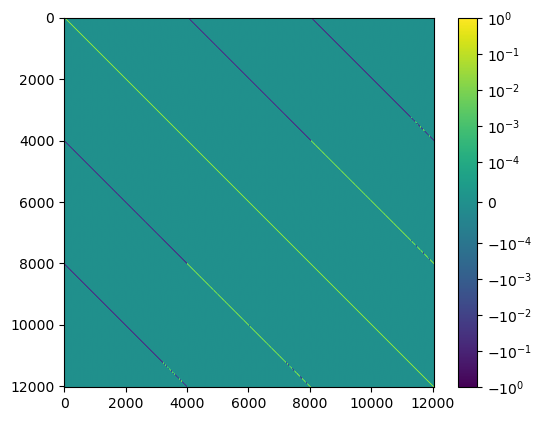

In [33]:
from matplotlib.colors import SymLogNorm
plt.imshow(jnp.diag(1/jnp.sqrt(jnp.diag(full_cov_sorted))) @ full_cov_sorted @ jnp.diag(1/jnp.sqrt(jnp.diag(full_cov_sorted))),
           norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-4))
plt.colorbar()

In [35]:
filt = (values.c < 0.3) &\
       (values.err_x1 + np.abs(values.x1) < 5) &\
       (values.err_c < .05) &\
       ((values.survey != 'ZTF') | (values.z < 0.1)) # &\
       # (values.z < 0.7) # &\
       # (np.random.uniform(0, 1, len(values)) < 0.3)
sum(filt)

3421

In [23]:
surveys = set(values[filt]['survey'])
survey_map = dict(zip(surveys, range(len(surveys))))
survey_id = jnp.array([survey_map[s] for s in values[filt]['survey']])

In [24]:
obs = Obs(mag=jnp.array(values[filt].magobs),
          variables=jnp.hstack([jnp.array(values[filt].x1), jnp.array(values[filt].c)]))

In [25]:
exp=dict(z=jnp.array(values[filt].z),
         survey_id=survey_id,
         survey_map=survey_map,
        )

In [26]:
n = len(values)

In [27]:
cov = FullCovariance(
    full_cov_sorted[:n, :n], full_cov_sorted[n:, n:], full_cov_sorted[:n, n:]
)

In [28]:
cov = cov.select(filt.values)

In [29]:
exp['map_survey'] = {v:k for v,k in zip(exp['survey_map'].values(), exp['survey_map'].keys())}

In [36]:
with open("/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/EDRIS_res/edris_salt_uchuu_0.2.pkl", 'rb') as file:
    obs = pickle.load(file)
    exp = pickle.load(file)
    cov = pickle.load(file)
    res = pickle.load(file)
    cov_res = pickle.load(file)

In [39]:
x0 = dict(H0=jnp.array([Planck15.H0.value]),
          Omega_m=jnp.array([Planck15.Om0]),
          coef=jnp.array([-0.14, 3.15]),
          variables=jnp.array(obs.variables.reshape((2, -1))),
          sigma_int=jnp.array([0.1]),
         )

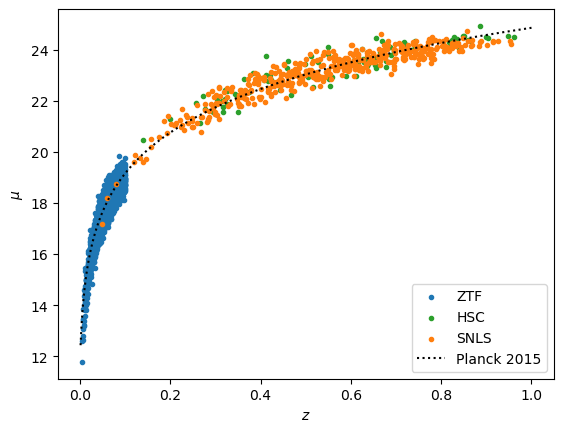

In [40]:
for survey in exp["survey_map"].keys():
    plt.scatter(exp['z'][exp['survey_id'] == exp['survey_map'][survey]],
                obs.mag[exp['survey_id'] == exp['survey_map'][survey]], # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
                c = survey_colors[survey],
                marker=".",
                label=survey)

plt.plot(np.linspace(1e-3, 1, 1000),
         flcdm(params, {'z':jnp.linspace(5e-3, 1, 1000)}),
         linestyle=':',
         color='k',
         label="Planck 2015")
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend()


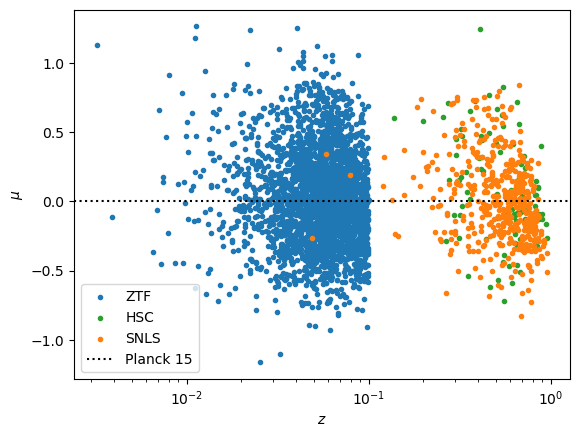

In [41]:
for survey in exp["survey_map"].keys():
    plt.scatter(exp['z'][exp['survey_id'] == exp['survey_map'][survey]],
                obs.mag[exp['survey_id'] == exp['survey_map'][survey]] - \
                flcdm(params, {'z':exp['z'][exp['survey_id'] == exp['survey_map'][survey]]}), 
                # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
                c = survey_colors[survey],
                marker=".",
                label=survey)

plt.axhline(0,
         linestyle=':',
         color='k',
         label="Planck 15")
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.semilogx()
plt.legend()


In [271]:
L = lambda x : likelihood(x, exp, cov, obs, cosmo=flcdm, truncated=False, restricted=False)

In [272]:
L(x0)

Array(-4065.56149243, dtype=float64)

In [273]:
fit_params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [274]:
res, loss, lmbda, iter_params = tncg(L, x0, **fit_params)

iter 0/1000. Loss: -4.1e+03->-4.4e+03(-3.4e+02), ρ=0.63, λ=10000.0
iter 1/1000. Loss: -4.4e+03->-4.5e+03(-65), ρ=0.64, λ=10000.0
iter 2/1000. Loss: -4.5e+03->-4.5e+03(-13), ρ=0.79, λ=3000.0
iter 3/1000. Loss: -4.5e+03->-4.5e+03(-13), ρ=0.77, λ=900.0
iter 4/1000. Loss: -4.5e+03->-4.5e+03(-6), ρ=0.67, λ=900.0
iter 5/1000. Loss: -4.5e+03->-4.5e+03(-1.1), ρ=0.79, λ=270.0
iter 6/1000. Loss: -4.5e+03->-4.5e+03(-1.2), ρ=0.84, λ=81.0
iter 7/1000. Loss: -4.5e+03->-4.5e+03(-1.5), ρ=0.83, λ=24.3
iter 8/1000. Loss: -4.5e+03->-4.5e+03(-1.6), ρ=0.79, λ=7.29
iter 9/1000. Loss: -4.5e+03->-4.5e+03(-1), ρ=0.72, λ=7.29
iter 10/1000. Loss: -4.5e+03->-4.5e+03(-0.25), ρ=0.77, λ=2.187
iter 11/1000. Loss: -4.5e+03->-4.5e+03(-0.12), ρ=0.67, λ=2.187
iter 12/1000. Loss: -4.5e+03->-4.5e+03(-0.016), ρ=0.70, λ=2.187
iter 13/1000. Loss: -4.5e+03->-4.5e+03(-0.0029), ρ=0.73, λ=2.187
iter 14/1000. Loss: -4.5e+03->-4.5e+03(-0.00067), ρ=0.75, λ=2.187
converged in 14 iterations
Completed in 10.26min


In [275]:
jax.tree.map(lambda x,y:x-y, res, x0)

{'Omega_m': Array([0.04225407], dtype=float64),
 'coef': Array([ 0.00745098, -0.06371749], dtype=float64),
 'sigma_int': Array([0.02435657], dtype=float64),
 'variables': Array([[ 9.58051686e-05,  1.60034279e-06,  1.79870563e-04, ...,
          6.12776819e-02, -6.71407622e-03, -3.10780236e-01],
        [-8.11661103e-05, -9.50975754e-07, -4.21263753e-04, ...,
         -9.49267958e-03,  2.80867576e-04, -2.62789709e-03]],      dtype=float64)}

In [276]:
hess = jax.hessian(L)(res)

In [277]:
n = {k1:hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"]*=n["coef"]
flatten_hess = jnp.vstack([np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()]) for k1 in hess.keys()])
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [160]:
with open("outdir/edris_salt_uchuu_0.2_no_H0.pkl", 'wb') as file:
    pickle.dump(obs, file)
    pickle.dump(exp, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

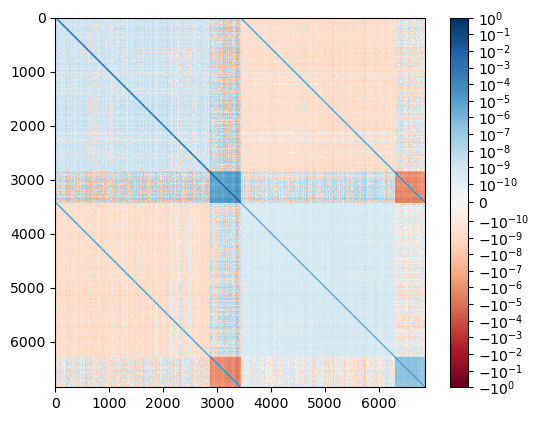

In [42]:
from matplotlib.colors import SymLogNorm
plt.imshow(cov_res, norm=SymLogNorm(linthresh=1e-10, vmin=-1, vmax=1), cmap="RdBu")
plt.colorbar()

In [43]:
potential_keys = ['H0', 'M0', 'Omega_m', 'Omega_r', 'Omega_l', 'coef', 'sigma_int']
latex_keys = {'H0': '$H_0$',
  'M0': '$M_0$',
  'Omega_m': '$\\Omega_m$',
  'Omega_r': '$\\Omega_r$',
  'Omega_l': '$\\Omega_l$',
  'coef': ['$\\alpha$', '$\\beta$'],
  'sigma_int': '$\\sigma_{int}$',
  'alpha': '$\\alpha$',
  'beta': '$\\beta$'}

In [44]:
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

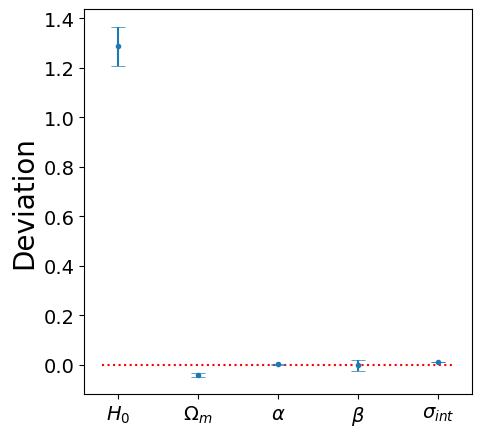

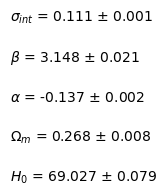

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs +=  list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5*n_pars+1, color='r', linestyle=':')
ax.set_xticks(5*np.arange(n_pars+1), _labels)
ax.set_ylabel('Deviation')
plt.errorbar(5*np.arange(n_pars+1), _diffs,
             yerr= jnp.sqrt(jnp.diag(cov_res)[:n_pars+1]),
             linestyle='',
             marker='.',
             capsize=5,
             capthick=.5)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1,1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars+1)*.4):
    fig.text(0, pos, _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}")


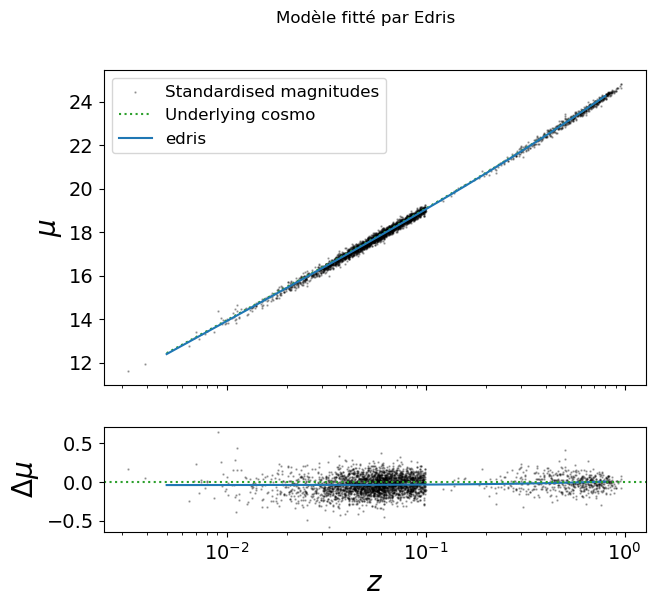

In [48]:
plot_hubble(obs, exp, res, cov_res, flcdm, x0)

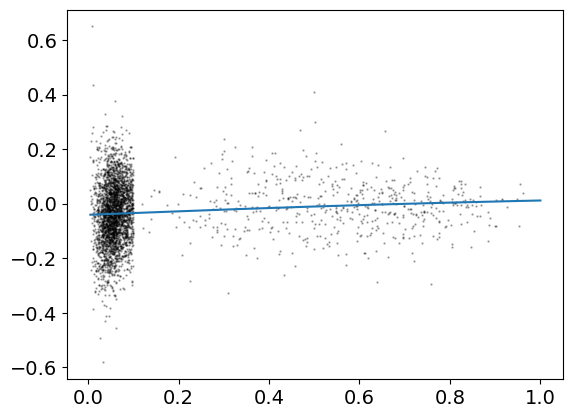

In [49]:
std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])
plt.scatter(exp["z"], std_mag - flcdm(x0, exp), color="k", s=0.5, alpha=0.3)
plt.plot(jnp.linspace(5e-3, 1.0, 1000),
         flcdm(res, {"z": jnp.linspace(5e-3, 1.0, 1000)}) - flcdm(x0, {"z":jnp.linspace(5e-3, 1.0, 1000)}))

In [50]:
mag_to_z = interp1d(flcdm(res, {"z":np.linspace(2e-3, 0.3, 10000)}),np.linspace(2e-3, 0.3, 10000))
z_cosmo_salt = mag_to_z(obs.mag[exp['survey_id']==exp['survey_map']["ZTF"]] - \
                        jnp.matmul(res['coef'], res['variables'])[exp['survey_id']==exp['survey_map']["ZTF"]])

In [51]:
edris_pv = (exp["z"][exp['survey_id']==exp['survey_map']["ZTF"]] - z_cosmo_salt) * c * 1e-3/(1+z_cosmo_salt)
true_pv = ((data_tot.z - data_tot.z_cosmo) * c *1e-3/(1+data_tot.z_cosmo)).loc[values[filt & (values.survey=='ZTF')].index]

In [52]:
data_ztf=data_tot.loc[values[filt & (values.survey=='ZTF')].index].copy()

In [54]:
true_pv.shape, edris_pv.shape

((2866,), (2866,))

In [90]:
edris_pv=np.array(edris_pv)

/tmp/ipykernel_9332/3807432255.py:22: RuntimeWarning: Mean of empty slice.
  [edris_pv[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) &\


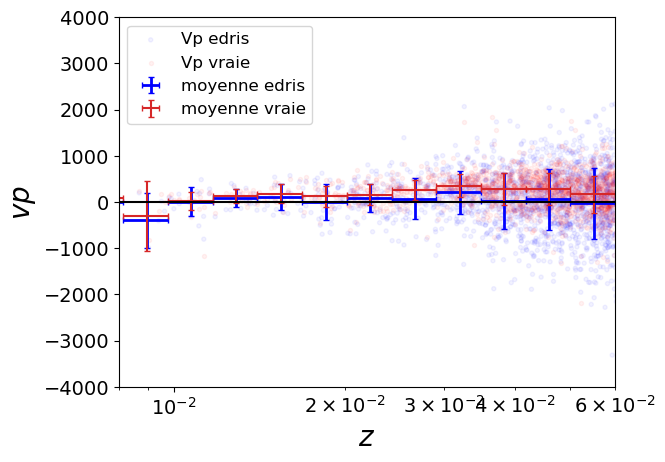

In [117]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            edris_pv,
            marker=".",
            alpha=0.05,
            color='b',
            linestyle='',
            label="Vp edris")

plt.scatter(data_ztf.z,
            true_pv,
            marker=".",
            alpha=0.05,
            color="red",
            label="Vp vraie")

z_max = 0.06
bounds = np.logspace(-2.72, np.log10(z_max), 20)
widths = (bounds[1:]-bounds[:-1])/2
bin_cen = (bounds[1:]+bounds[:-1])/2

plt.errorbar(bin_cen,
             [edris_pv[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) &\
                       (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_cen + width/2)].mean() for z_cen,width in zip(bin_cen,widths)],
             yerr=[edris_pv[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) & \
                            (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_cen + width/2)].std() for z_cen,width in zip(bin_cen,widths)],
             xerr=widths,
             linestyle='',
             color='blue',
             linewidth=2,
             capsize=2,
             label="moyenne edris")

plt.errorbar(bin_cen,
             [true_pv.loc[data_ztf.z.between(z_cen - width/2, z_cen + width/2)].mean() for z_cen,width in zip(bin_cen,widths)],
             yerr=[true_pv.loc[data_ztf.z.between(z_cen - width/2, z_cen + width/2)].std() for z_cen,width in zip(bin_cen,widths)],
             xerr=widths,
             linestyle='',
             color='tab:red',
             capsize=2,
             label="moyenne vraie")

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.ylim(-4000, 4000)
plt.semilogx()
plt.xlim(0.008, 0.06)
plt.axhline(0, color='k')

/tmp/ipykernel_9332/3738662642.py:7: RuntimeWarning: Mean of empty slice.
  mean_delta = [(true_pv[filt] - edris_pv).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) & \
/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_9332/3738662642.py:7: RuntimeWarning: Mean of empty slice.
  mean_delta = [(true_pv[filt] - edris_pv).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) & \
/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_9332/3738662642.py:7: RuntimeWarning: Mean of empty slice.
  mean_delta = [(true_pv[filt] - edris_pv).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2)

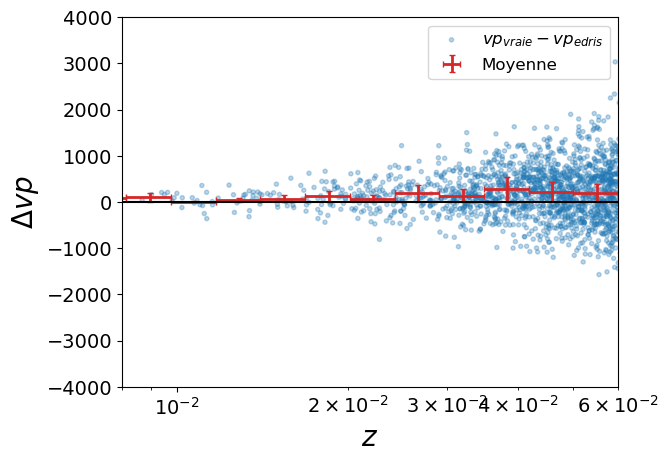

In [109]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            true_pv - edris_pv,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{edris}$")
mean_delta = [(true_pv[filt] - edris_pv).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) & \
                                         (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_cen + width/2)].mean() for z_cen,width in zip(bin_cen,widths)]
err_delta = [(true_pv[filt] - edris_pv).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_cen - width/2) & \
                                        (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_cen + width/2)].mean() for z_cen,width in zip(bin_cen,widths)]
plt.errorbar(bin_cen,
             mean_delta,
             yerr=err_delta,
             xerr=widths,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.semilogx()
plt.xlim(0.008, 0.06)

plt.axhline(0, color='k')

In [111]:
(true_pv - edris_pv).values[data_ztf.z < 0.06].mean(), (true_pv - edris_pv).values[data_ztf.z < 0.06].std()

(187.4019104913565, 536.5873786341289)

In [114]:
edris_pv[data_ztf.z < 0.06].mean(), edris_pv[data_ztf.z < 0.06].std()

(35.96320237346793, 640.9856965533979)

### Vpec Cov

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flip import fitter, plot_utils, utils
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")

/tmp/ipykernel_1267104/2460183982.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [33]:
ktt, ptt = np.loadtxt(os.path.join(data_path,"power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path,"power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path,"power_spectrum_mm.txt"))


In [58]:
import h5py
file = h5py.File('outdir/den_powspec_Uchuu.h5py', 'r')

In [64]:
k_uchuu = np.array(file['DivergencePowerSpectrum']['k'])
p_uchuu = np.array(file['DivergencePowerSpectrum']['p'])
file.close()

[]

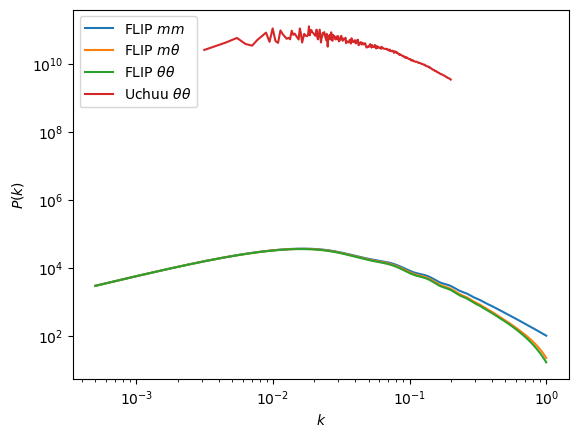

In [107]:
plt.plot(kmm, pmm, label=r'FLIP $mm$')
plt.plot(kmt, pmt, label=r'FLIP $m\theta$')
plt.plot(ktt, ptt, label=r'FLIP $\theta\theta$')
plt.plot(k_uchuu, p_uchuu, label=r'Uchuu $\theta\theta$')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')
plt.legend()
plt.loglog()


In [ ]:
values = values.join(data_tot[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi

In [73]:
values["rcom"] = Planck15.comoving_distance(values.z).value

In [74]:
grid_window = pd.read_parquet(os.path.join(data_path,"grid_window_m.parquet"))

In [75]:
from astropy.cosmology import z_at_value
import astropy.units as u
z_at_value(Planck15.comoving_distance, 1000*u.Mpc)

<Quantity 0.23973108 redshift>

In [76]:
values[filt & (values.rcom < 1000)]

z            t0        x0        x1         c     magobs  \
ZTF_19     0.049678  58742.694554  0.001602 -0.204705  0.026278  17.496871   
ZTF_47     0.014811  59027.411017  0.036900  2.292553 -0.091393  14.090993   
ZTF_53     0.035193  58824.547792  0.005479  0.045261 -0.103647  16.161854   
ZTF_56     0.055217  58998.090905  0.001540  0.587283 -0.070132  17.539911   
ZTF_66     0.032764  58769.690992  0.003297  0.455272  0.101725  16.713141   
...             ...           ...       ...       ...       ...        ...   
SNLS_7692  0.185350  54478.714487  0.000052  0.246017  0.256513  21.218757   
SNLS_7697  0.212250  53686.963788  0.000056  0.632993  0.129196  21.129304   
SNLS_7705  0.224450  53370.040327  0.000069 -2.227312 -0.071492  20.905471   
SNLS_7747  0.200250  54101.967605  0.000059 -0.640076  0.102904  21.078958   
HSC_6450   0.199850  58800.360987  0.000048 -1.121678  0.144650  21.306069   

           valid    err_t0    err_x0    err_x1     err_c  err_magobs  \
ZTF_19      True  0.020898  0.000045  0.026225  0.024750    0.030688   
ZTF_47      True  0.005312  0.001006  0.026056  0.023832    0.029586   
ZTF_53      True  0.047642  0.000164  0.034294  0.027598    0.032478   
ZTF_56      True  0.065713  0.000044  0.069395  0.025984    0.030825   
ZTF_66      True  0.067264  0.000099  0.090903  0.027725    0.032732   
...          ...       ...       ...       ...       ...         ...   
SNLS_7692   True  0.151674  0.000001  0.145557  0.024811    0.030230   
SNLS_7697   True  0.081770  0.000002  0.137726  0.026881    0.033321   
SNLS_7705   True  0.375614  0.000003  0.321591  0.035037    0.052273   
SNLS_7747   True  0.055720  0.000002  0.067466  0.025175    0.030796   
HSC_6450    True  0.337371  0.000002  0.271368  0.039913    0.055744   

                  mu    err_mu survey        ra       dec        rcom  
ZTF_19     17.385436  0.054076    ZTF  1.955474  1.133995  217.299552  
ZTF_47     14.699840  0.053931    ZTF  1.472339  0.678500   65.322972  
ZTF_53     16.494680  0.062223    ZTF -0.624708  1.133746  154.472971  
ZTF_56     17.843046  0.059285    ZTF -0.014156  0.404661  241.208692  
ZTF_66     16.456446  0.062806    ZTF  1.308927  0.586894  143.892953  
...              ...       ...    ...       ...       ...         ...  
SNLS_7692  20.445182  0.055051   SNLS -2.514138 -0.070449  784.035843  
SNLS_7697  20.810956  0.058312   SNLS  2.689383 -0.302032  891.669557  
SNLS_7705  20.818848  0.086242   SNLS -2.498469 -0.077842  939.965090  
SNLS_7747  20.665200  0.057482   SNLS -0.524787  0.039871  843.849305  
HSC_6450   20.693388  0.141916    HSC -2.510747 -0.097822  842.249893  

[1295 rows x 18 columns]

In [87]:
coordinates = np.array([values[filt & (values.rcom < 1000)]['ra'],
                        values[filt & (values.rcom < 1000)]['dec'],
                        values[filt & (values.rcom < 1000)]['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k_uchuu, p_uchuu * utils.Du(k_uchuu, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)


ValueError: Min pw spectrum k is too high, please take a lower one. Use kmin parameter to lower bound integration.

In [48]:
covariance_fit.compute_full_matrix()

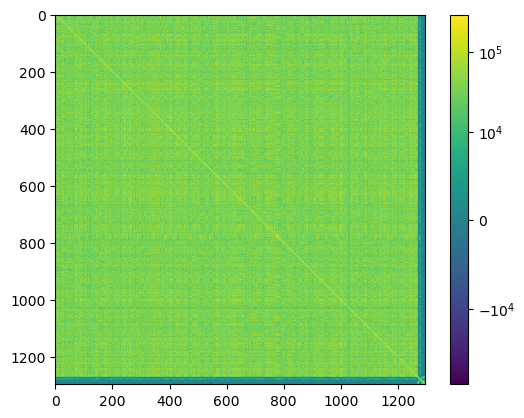

In [49]:
from matplotlib.colors import SymLogNorm
plt.imshow(covariance_fit.covariance_dict['vv'][0], norm=SymLogNorm(linthresh=1e4))
plt.colorbar()

In [82]:
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values[filt & (values.rcom < 1000)].z.values]).T @ \
             np.array([1/values[filt & (values.rcom < 1000)].z.values]))

In [83]:
salt_cov = full_cov_sorted[:n, :n][filt & (values.rcom < 1000)][:,filt & (values.rcom < 1000)]

In [84]:
values[filt & (values.rcom < 1000) & (values.z > 0.07)]

z            t0        x0        x1         c     magobs  \
SNLS_522   0.22545  53277.493202  0.000061 -0.072893  0.095408  21.041485   
SNLS_886   0.21055  53749.491821  0.000060 -0.745899  0.025416  21.070082   
SNLS_1190  0.19275  54029.861424  0.000080  1.395975  0.040586  20.745711   
SNLS_1344  0.23965  53918.582604  0.000056  0.918458  0.020312  21.129585   
SNLS_1771  0.07945  54004.926872  0.000506 -0.507228  0.032222  18.747510   
SNLS_1942  0.22595  53883.094264  0.000034  0.024008  0.196344  21.674483   
SNLS_2438  0.23785  53668.396941  0.000045 -0.509192  0.072007  21.379980   
SNLS_2673  0.17505  53812.856511  0.000094 -0.127121  0.051679  20.581195   
SNLS_2838  0.13375  53215.689813  0.000197 -1.769682 -0.040935  19.772646   
SNLS_3298  0.14565  53424.126297  0.000207 -0.545689 -0.118337  19.717725   
SNLS_3691  0.15705  53234.598349  0.000134  0.962943  0.041276  20.189075   
SNLS_3811  0.12165  54607.594128  0.000181 -0.412092  0.112786  19.862692   
SNLS_4008  0.13895  53567.513007  0.000228  1.263709 -0.030192  19.614884   
SNLS_4079  0.23525  54153.927868  0.000042  0.407154  0.099991  21.458823   
SNLS_5463  0.20715  53929.427405  0.000060 -1.062900  0.091185  21.054798   
SNLS_5476  0.19525  53633.487983  0.000044 -1.656241  0.189770  21.405898   
SNLS_5817  0.15625  53522.817901  0.000101 -1.273270  0.048521  20.501314   
SNLS_6151  0.11955  53816.079720  0.000228  0.794708  0.071053  19.613928   
SNLS_6164  0.22215  52927.817020  0.000050 -2.620521  0.003729  21.266063   
SNLS_6633  0.23115  54108.485574  0.000073  0.725304 -0.019270  20.856823   
SNLS_7692  0.18535  54479.637191  0.000052  1.051837  0.274271  21.226117   
SNLS_7697  0.21225  53686.962294  0.000057  0.580574  0.126961  21.123434   
SNLS_7705  0.22445  53370.762586  0.000066 -1.937890 -0.052234  20.961100   
SNLS_7747  0.20025  54101.969118  0.000059 -0.583697  0.103447  21.084975   
HSC_6450   0.19985  58800.414019  0.000048 -1.085571  0.136246  21.301445   
HSC_9036   0.13855  57813.350414  0.000105 -0.573223  0.184440  20.450535   

          valid        err_x0    err_x1     err_c  err_magobs         mu  \
SNLS_522   True  2.835983e-07  0.031979  0.003245    0.005030  20.730745   
SNLS_886   True  5.859823e-07  0.050099  0.006685    0.010671  20.885597   
SNLS_1190  True  1.993340e-07  0.026139  0.001895    0.002693  20.813302   
SNLS_1344  True  2.016907e-07  0.034890  0.003019    0.003880  21.194185   
SNLS_1771  True  7.185631e-07  0.006719  0.000961    0.001541  18.574999   
SNLS_1942  True  4.470435e-07  0.539093  0.015293    0.014205  21.059360   
SNLS_2438  True  4.125102e-07  0.062857  0.006290    0.009994  21.081872   
SNLS_2673  True  2.000748e-06  0.074251  0.007776    0.023226  20.400607   
SNLS_2838  True  4.115985e-07  0.009966  0.001607    0.002269  19.653837   
SNLS_3298  True  6.863913e-07  0.014140  0.002282    0.003597  20.014091   
SNLS_3691  True  2.672697e-07  0.017925  0.001612    0.002162  20.193869   
SNLS_3811  True  4.254758e-07  0.014365  0.001644    0.002548  19.449724   
SNLS_4008  True  6.199830e-07  0.015362  0.001779    0.002956  19.886908   
SNLS_4079  True  1.477574e-07  0.035715  0.003164    0.003849  21.200853   
SNLS_5463  True  2.762638e-07  0.027055  0.003287    0.004961  20.618758   
SNLS_5476  True  2.673407e-07  0.026351  0.004451    0.006633  20.576248   
SNLS_5817  True  1.755660e-07  0.014845  0.001448    0.001894  20.170215   
SNLS_6151  True  2.063204e-06  0.038591  0.003646    0.009827  19.501372   
SNLS_6164  True  2.411483e-07  0.030436  0.003740    0.005260  20.887443   
SNLS_6633  True  2.881460e-07  0.029893  0.002351    0.004312  21.019067   
SNLS_7692  True  2.181748e-07  0.038042  0.003304    0.004587  20.509419   
SNLS_7697  True  3.795785e-07  0.051403  0.004607    0.007261  20.804786   
SNLS_7705  True  3.122861e-07  0.019161  0.004469    0.005144  20.854332   
SNLS_7747  True  2.739478e-07  0.026905  0.003212    0.005058  20.677399   
HSC_6450   True  5.022219e-07  0.0486

In [103]:
sort = np.argsort(values[filt][values[filt].rcom < 1000].z.values)

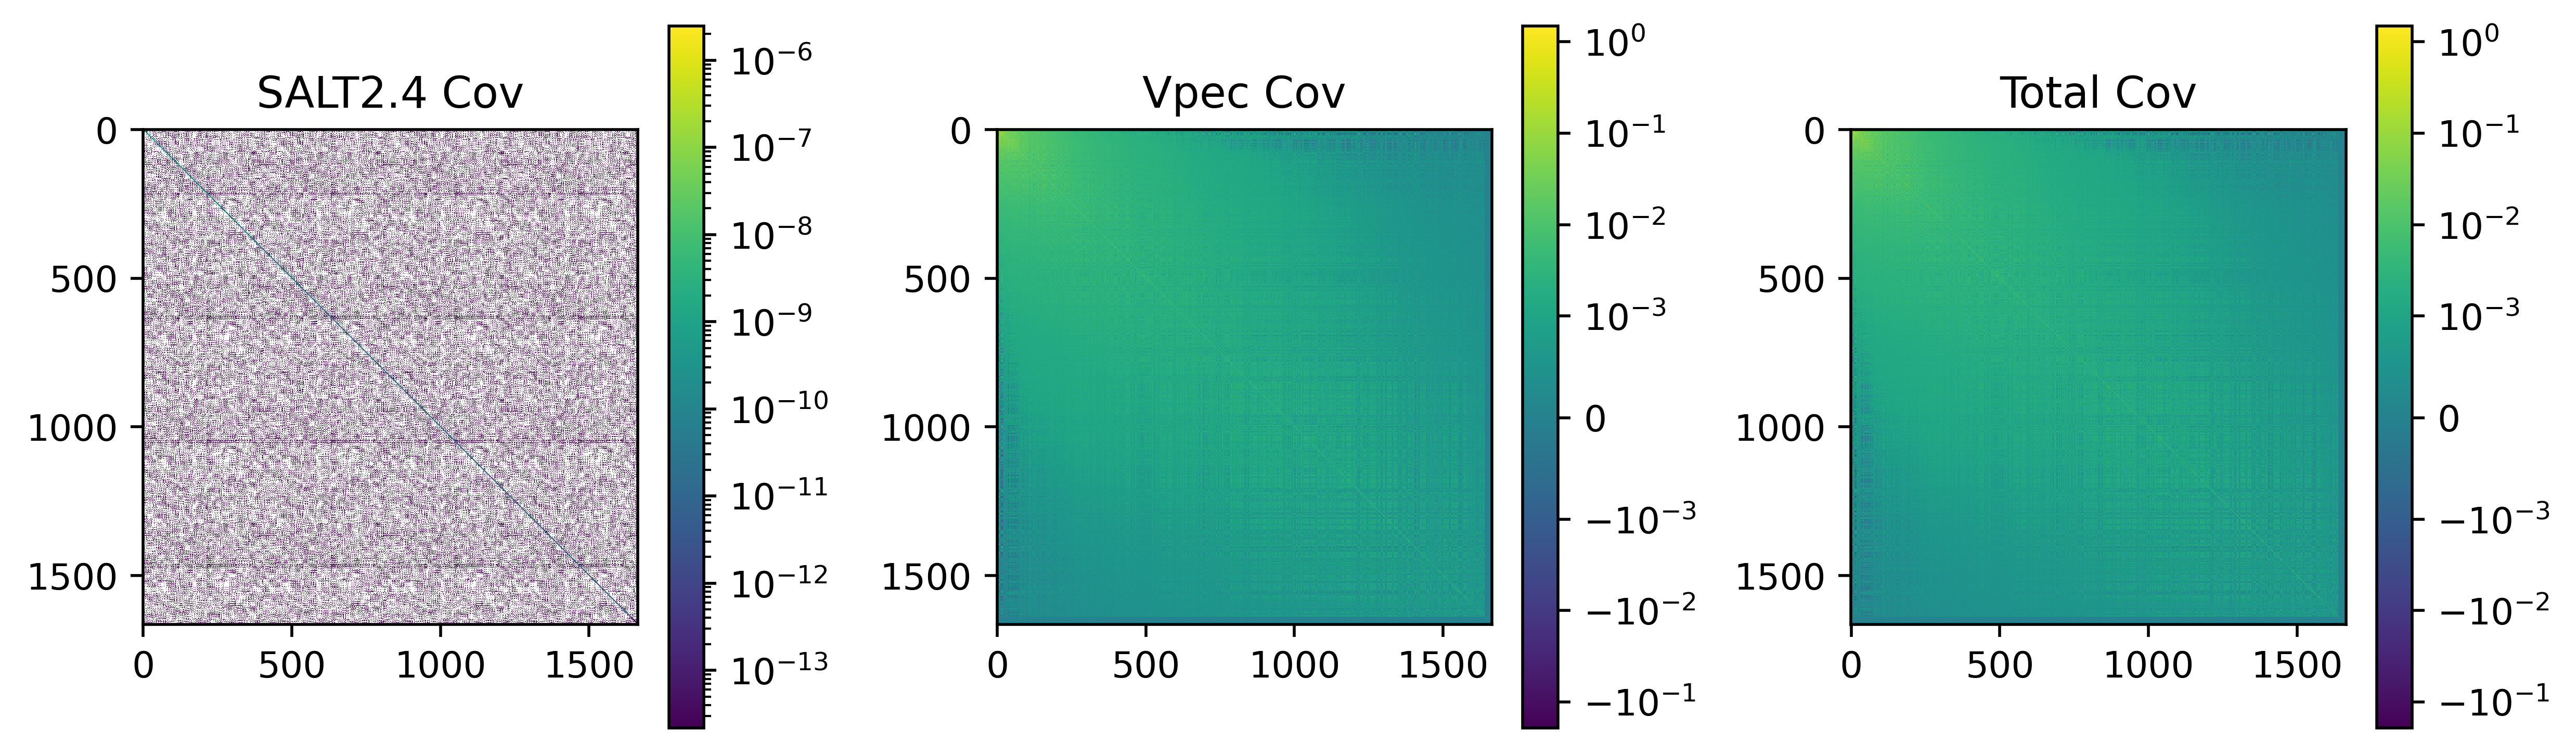

In [104]:
fig, (ax1, ax2, ax3)=plt.subplots(ncols=3, figsize=(10,3), dpi=500)
im1=ax1.imshow(salt_cov[sort][:,sort], norm="log")
ax1.set_title("SALT2.4 Cov")
plt.colorbar(im1, ax=ax1)

im2=ax2.imshow(vpec_cov[sort][:,sort], norm=SymLogNorm(linthresh=1e-3))
ax2.set_title("Vpec Cov")
plt.colorbar(im2, ax=ax2)

im3=ax3.imshow(salt_cov[sort][:,sort] + vpec_cov[sort][:,sort], norm=SymLogNorm(linthresh=1e-3))
ax3.set_title("Total Cov")
plt.colorbar(im3, ax=ax3)
plt.tight_layout()

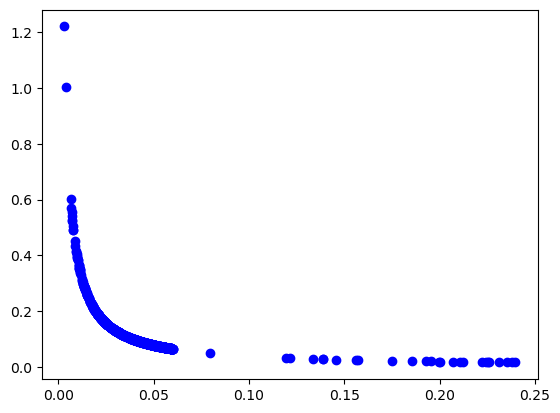

In [126]:
plt.plot(values[filt & (values.rcom < 1000)].z, np.sqrt(np.diag(vpec_cov)), 'ob')

Text(0.5, 1.0, 'Incertitudes')

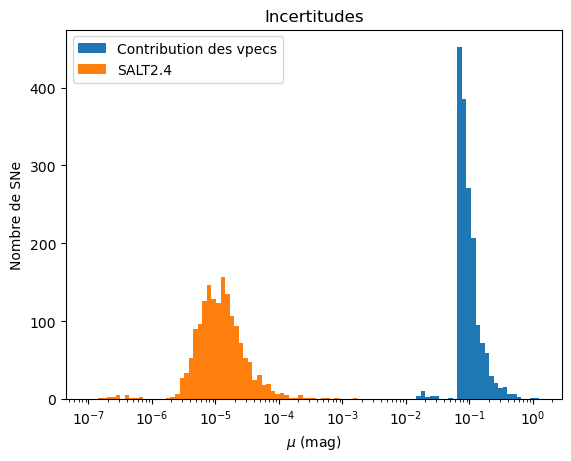

In [86]:
_=plt.hist(np.sqrt(np.diag(vpec_cov)), bins=np.logspace(-7, 0.1, 100), label='Contribution des vpecs')
_=plt.hist(np.sqrt(np.diag(salt_cov)), bins=np.logspace(-7, 0.1, 100), label='SALT2.4')
plt.semilogx()
plt.legend()
plt.xlabel("$\mu$ (mag)")
plt.ylabel("Nombre de SNe")
plt.title('Incertitudes')

### Likelihood profile

In [ ]:
L = lambda x: likelihood(x, exp, cov_sel, obs, cosmo=cosmo, truncated=False, restricted=False)

interest : sigma_int, alpha, beta, Omega_m, Omega_r, Omega_l, H0

In [ ]:
x0 = {
    "Omega_m": jnp.array([Planck18.Om0]),
    "Omega_r": jnp.array([5e-5]),
    "Omega_l": jnp.array([Planck18.Ode0]),
    "H0": jnp.array([Planck18.H0.value]),
    "sigma_int": jnp.array([0.1]),
    "coef": jnp.array([-0.14, 3.15]),
    "variables": jnp.array(obs.variables.reshape((2, -1))),
}
x0

In [ ]:
def profile(Omega_m=Planck18.Om0, Omega_r=5e-5, Omega_l=Planck18.Ode0, H0=Planck18.H0.value, sigma_int=0.1, alpha=-0.14, beta=3.15):
    x_ = x0.copy()
    x_.update(**{
            "Omega_m": jnp.array([Omega_m]),
            "Omega_r": jnp.array([Omega_r]),
            "Omega_l": jnp.array([Omega_l]),
            "H0": jnp.array([H0]),
            "sigma_int": jnp.array([sigma_int]),
            "coef": jnp.array([alpha, beta]),
            "variables": jnp.array(obs.variables.reshape((2, -1))),}
             )
    return L(x_)

In [ ]:
profile_vect = jax.vmap(profile)

In [ ]:
lims = dict(sigma_int=(0.05, 0.4),
            alpha=(-0.3,0.05),
            beta=(3.0,3.5),
            Omega_m=(0.1,0.4),
            Omega_l=(0.5, 0.8),
            H0=(60,70))

In [ ]:
grids={key:jnp.linspace(*lims[key], 100) for key in lims.keys()}

In [ ]:
latex_labels = ["$\\sigma_{int}$", "$\\alpha$", "$\\beta$", "$\\Omega_m$", "$\\Omega_l$", "$H_0$"]

In [ ]:
import matplotlib

fig, axs = plt.subplots(nrows=len(lims), ncols=len(lims), sharex="col", figsize=(3*len(lims),3*len(lims)), dpi=100)

for i, key in enumerate(lims.keys()):
    
    axs[i,i].plot(grids[key], profile_vect(**{key:grids[key]}))
    axs[i,0].set_ylabel(latex_labels[i])
    axs[len(lims.keys())-1,i].set_xlabel(latex_labels[i])

    for j, key_2 in enumerate(lims.keys()):
        
        if j > i:
            axs[i,j].remove()
            continue
        elif j==i:
            if j!=0:
                axs[i,i].yaxis.tick_right()
            continue
        if j > 0:
            axs[i,j].set_yticklabels([])
            axs[i,j].set_yticklabels([], minor=True)
        
        mesh = jnp.meshgrid(grids[key], grids[key_2])
        axs[i,j].imshow(profile_vect(**{key:mesh[0].reshape(-1), key_2:mesh[1].reshape(-1)}).reshape(len(grids[key]), len(grids[key_2])),
                        vmin=-2500, vmax=1000,
                        extent=(*lims[key_2], *lims[key]),
                        aspect="auto",
                        cmap='rainbow')

In [ ]:
plt.close()

### NACL

In [ ]:
from nacl.train import TrainSALT2Like

from scipy.sparse import csc_matrix

trainer = TrainSALT2Like.load('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/test.pkl')

with np.load('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/test.npz') as dat:
    cov_matrix=dat['arr_0']

pars_trained = trainer.log[-1].pars
v_trained = trainer.log[-1].v

In [ ]:
data_nacl = pandas.DataFrame(trainer.tds.sn_data.nt, index = trainer.tds.sn_data.nt["sn"]).drop(columns='index')

n = len(data_nacl)

cplt_perm = jnp.hstack([*[trainer.tds.sn_data.sn_index+k*n for k in range(3)]])

cov_ordered = cov_matrix[:3*n,:3*n][cplt_perm][:, cplt_perm]

data_nacl["err_x0"] = jnp.sqrt(jnp.diag(cov_ordered[:n,:n]))
data_nacl["err_x1"] = jnp.sqrt(jnp.diag(cov_ordered[n:2*n,n:2*n]))
data_nacl["err_c"] = jnp.sqrt(jnp.diag(cov_ordered[2*n:3*n,2*n:3*n]))
# data_nacl["err_gamma_sn"] = jnp.sqrt(jnp.diag(cov_matrix[borders[-2]:,borders[-2]:]))[trainer.tds.sn_data.sn_index]

data_nacl["tmax"] = pars_trained["tmax"]._pars[trainer.tds.sn_data.sn_index]
data_nacl["x0"] = pars_trained["X0"]._pars[trainer.tds.sn_data.sn_index]
data_nacl["x1"] = pars_trained["X1"]._pars[trainer.tds.sn_data.sn_index]
data_nacl["c"] = pars_trained["c"]._pars[trainer.tds.sn_data.sn_index]
# data_nacl["gamma_sn"] = pars_trained["gamma_sn"]._pars[trainer.tds.sn_data.sn_index]
data_nacl.reset_index(drop=True, inplace=True)

In [ ]:
with open("outdir/SN_Uchuu.pkl", "rb") as f:
    data_truth = pickle.load(f)

data_nacl["z_cosmo"]=np.NaN
for i in data_nacl.index:
    if data_nacl.loc[i, 'sn'] in data_truth.index:
        data_nacl.loc[i, "z_cosmo"] = data_truth.loc[data_nacl.loc[i, 'sn'], "z_cosmo"]

In [ ]:
alpha = -0.14
beta=3.15

A = csc_matrix(jnp.diag(jnp.hstack([-2.5 / (np.log(10) * np.array(data_nacl["x0"])), jnp.ones(n),jnp.ones(n)])))

cov_mb = (A @ csc_matrix(cov_ordered) @ A.T).toarray()

import sncosmo
M0=sncosmo.SALT2Source(modeldir='./data/SALT_snf', m0file='nacl_m0_test.dat', m1file='nacl_m1_test.dat', clfile='nacl_color_law_test.dat').peakmag('bessellb', 'ab')

data_nacl['Mb'] = -2.5*np.log10(data_nacl['x0']) + M0

data_nacl['cov_x0'] = jnp.diag(cov_ordered[:n,:n])
data_nacl['cov_Mb'] = jnp.diag(cov_mb)[:n]
data_nacl['cov_x1'] = jnp.diag(cov_mb)[n:2*n]
data_nacl['cov_c'] = jnp.diag(cov_mb)[2*n:3*n]

In [ ]:
data_nacl.columns

In [ ]:
from edris.models import FullCovariance

cov = FullCovariance(cov_mb[:n,:n], cov_mb[n:,n:], cov_mb[:n,n:])

In [ ]:
filt = (jnp.abs(pars_trained['c']._pars) < 0.3) & \
        (jnp.sqrt(data_nacl['cov_c'].to_numpy()) < 0.1) & \
        (jnp.abs(jnp.array(data_nacl['x1'])) + data_nacl['cov_x1'].to_numpy() < 5) & \
        (data_nacl['cov_x1'].to_numpy() < 1)
data_nacl['used_edris']=filt
sum(filt)

In [ ]:
cov_sel = cov.select(data_nacl['used_edris'].to_numpy())

n = sum(data_nacl['used_edris'])

exp={'z':jnp.array(data_nacl[data_nacl['used_edris']].z)}

from edris.tools import log_bins
exp['z_bins'] = log_bins(exp['z'].min() - 1e-4, exp['z'].max() + 1e-4, 5)

from edris.models import Obs

obs=Obs(jnp.array(data_nacl[data_nacl["used_edris"]].Mb),
        jnp.hstack([np.array(data_nacl[data_nacl["used_edris"]].x1), 
                    np.array(data_nacl[data_nacl["used_edris"]].c)]))

In [ ]:
from edris.tools import linear_interpolation
from astropy.constants import c

def integrand(Omega_m, u):
    return 1 / jnp.sqrt(Omega_m + (1-Omega_m) * u**6)


def dist(
    z,
    Omega_m=Planck15.Om0,
    H0=Planck15.H0.value,
    nstep=10000,
    **kwargs
):
    dh = c.value * 1e-3 / H0
    u = 1 / jnp.sqrt(1 + z)
    umin = 0.02
    step = (1 - umin) / nstep
    _u = jnp.arange(umin + 0.5 * step, 1, step)
    csum = jnp.cumsum(integrand(Omega_m, _u[-1::-1]))[-1::-1]
    R = linear_interpolation(u, csum, _u - 0.5 * step) * 2 * step * dh
    return R

def cosmo(params, exp):
    return 5.0 * jnp.log10(abs(exp["z"] + 1.0) * dist(exp["z"], **params)) + params.get("M0", 25-19.3)

In [ ]:
x0 = {
    # "mu_bins": jnp.array(mag_Planck15(exp['z_bins'])),
    "Omega_m": jnp.array([Planck15.Om0]),
    # "Omega_r": jnp.array([5e-5]),
    # "Omega_l": jnp.array([Planck15.Ode0]),
    "H0": jnp.array([Planck15.H0.value]),
    "coef": jnp.array([-0.14, 3.15]),
    "variables": jnp.array(obs.variables.reshape((2, -1))),
    # "sigma_int":jnp.array([0.1]),
    # "M0":jnp.array([25 - 19.3]),
}

In [ ]:
plt.scatter(data_nacl["z"], data_nacl["Mb"] + 0.14*data_nacl['x1'] - 3.15 * data_nacl['c'], linestyle='', marker=".")
plt.plot(np.linspace(0.001, 1.2, 100), cosmo(x0, {"z":np.linspace(0.001, 1.2, 100)}))

In [ ]:
L = lambda x: restrict(likelihood,{"sigma_int": .1,},)(x, exp, cov_sel, obs, cosmo=cosmo, truncated=False, restricted=False)
# L = lambda x: likelihood(x, exp, cov_sel, obs, cosmo=cosmo, truncated=False, restricted=False)
params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **params)

In [ ]:
res

In [ ]:
hess = jax.hessian(L)(res)

In [ ]:
n = {k1:hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"]*=n["coef"]
flatten_hess = jnp.vstack([np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()]) for k1 in hess.keys()])
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [ ]:
plot_hubble(obs, res, cov_res, cosmo, x0)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
labels, values, diffs = [], [], []
for k in keys:
    labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    values += list(res[k])
    diffs +=  list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5*n_pars+1, color='r', linestyle=':')
ax.set_xticks(5*np.arange(n_pars+1), labels)
ax.set_ylabel('Reduced deviation')
plt.errorbar(5*np.arange(n_pars+1), np.array(diffs)/np.array(values),
             yerr= jnp.sqrt(jnp.diag(cov_res)[:n_pars+1])/np.array(np.abs(values)),
             linestyle='',
             marker='.',
             capsize=5,
             capthick=.5)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1,1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars+1)*.4):
    fig.text(0, pos, labels[i] + f" = {values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}")


In [ ]:
with open("outdir/edris_nacl_uchuu.pkl", "wb") as file:
    pickle.dump(exp, file)
    pickle.dump(obs, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(hess, file)

In [ ]:
with open("outdir/edris_nacl_uchuu.pkl", "rb") as file:
    exp = pickle.load(file)
    obs = pickle.load(file)
    cov = pickle.load(file)
    res = pickle.load(file)
    hess = pickle.load(file)

In [ ]:
std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

In [ ]:
std_mag_ztf = std_mag[np.array(data_nacl[data_nacl.used_edris].sn < 10000)]

In [ ]:
mag_to_z_cosmo = jnp.vectorize(interp1d(cosmo(res, {"z": jnp.linspace(5e-3, 0.1, 10000)}), np.linspace(5e-3, 0.1,10000)), signature='(k)->(k)')


In [ ]:
len(data_nacl[data_nacl.z_cosmo > 0].z_cosmo)

In [ ]:
data_nacl["ztf_vpec"] = (data_nacl.z_cosmo > 0) & (data_nacl.used_edris)
data_nacl["calc_z_cosmo"] = np.NaN
data_nacl.loc[data_nacl[data_nacl.ztf_vpec].index, "calc_z_cosmo"] = mag_to_z_cosmo(std_mag_ztf)

In [ ]:
plt.scatter(data_nacl[data_nacl.ztf_vpec].z_cosmo, data_nacl[data_nacl.ztf_vpec].calc_z_cosmo, marker=".")

In [ ]:
with open("outdir/SN_Uchuu_nacl_res.pkl", "wb") as file:
    pickle.dump(data_nacl, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

### Bin number ?

In [ ]:
from tqdm.auto import tqdm

In [ ]:
n_b = [2, 3, 4, 5, 6, 7, 8, 9, 10]
n = len(index)

In [ ]:
z_bins = [
    edris.tools.log_bins(data.loc[index]["z"].min() - 1e-4, 0.06, n_bins)
    for n_bins in n_b
]

In [ ]:
results = []
covs = []

for n_bins in tqdm(n_b):
    exp, cov, obs = sncosmo_to_edris(res_sn, data, index[goods], n_bins=n_bins)
    x0 = {
        "mu_bins": jnp.zeros(len(exp["z_bins"])),
        "coef": jnp.array([-0.14, 3.15]),
        "variables": jnp.array(obs.variables.reshape((2, -1))),
    }
    # Apply a first standardization guess
    delta_mu = obs.mag - edris.models.sn1a_model(x0, exp).mag
    interpol_matrix = edris.tools.linear_interpolation_matrix(
        jnp.log10(exp["z"]), jnp.log10(exp["z_bins"])
    )
    mu_start = jnp.linalg.solve(
        jnp.dot(interpol_matrix.T, interpol_matrix),
        jnp.dot(interpol_matrix.T, delta_mu),
    )
    x0["mu_bins"] = mu_start
    L = lambda x: edris.tools.restrict(
        edris.models.likelihood,
        {
            "sigma_int": 0.1,
        },
    )(
        x,
        exp,
        cov_sel,
        obs,
        cosmo=edris.cosmo.binned_cosmo,
        truncated=False,
        restricted=False,
    )
    res, loss, lmbda, iter_params = edris.minimize.tncg(
        L,
        x0,
        1000,
        lmbda=1e4,
        tol=1e-2,
        verbose=True,
        max_iter_tncg=None,
    )
    hess = jax.hessian(L)(res)
    n_var = len(hess["coef"]["coef"])
    n_bins = len(hess["mu_bins"]["mu_bins"])
    n = hess["variables"]["variables"].shape[1]
    row1 = jnp.hstack(
        (
            hess["coef"]["coef"],
            hess["coef"]["mu_bins"],
            hess["coef"]["variables"].reshape(n_var, n * n_var),
        )
    )
    row2 = jnp.hstack(
        (
            hess["mu_bins"]["coef"],
            hess["mu_bins"]["mu_bins"],
            hess["mu_bins"]["variables"].reshape(n_bins, n * n_var),
        )
    )
    row3 = jnp.hstack(
        (
            hess["variables"]["coef"].reshape(n * n_var, n_var),
            hess["variables"]["mu_bins"].reshape(n * n_var, n_bins),
            hess["variables"]["variables"].reshape(n * n_var, n * n_var),
        )
    )
    flatten_hessian = jnp.vstack((row1, row2, row3))
    cov_res = jnp.linalg.inv(0.5 * flatten_hessian)
    covs.append(cov_res)
    results.append(res)

In [ ]:
n_var = 2
for img, n_bins in zip(covs, n_b):
    fig, ax2 = plt.subplots(figsize=(7, 7))
    sigma_inv = jnp.diag(1 / jnp.sqrt(jnp.diag(img)))
    corr = jnp.matmul(sigma_inv, jnp.matmul(img, sigma_inv))

    im2 = ax2.imshow(
        corr[: n_bins + 2, : n_bins + 2], norm=colors.Normalize(vmin=-1.0, vmax=1.0)
    )
    ax2.set_title("Correlation of coefs and mu_bins")
    ax2.figure.colorbar(im2, ax=ax2)

    plt.show()

In [ ]:
plt.figure("residuals", figsize=(10, 5))
for bins, cov, res in zip(z_bins, covs, results):
    plt.errorbar(
        bins,
        res["mu_bins"] - (jnp.array(cosmo.distmod(np.array(bins))) - 19.3),
        yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + len(bins), 2 : 2 + len(bins)])),
        label=f"{len(bins)}",
    )
plt.title("Residuals")
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{Planck\_18}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale("log")
plt.hlines(0, 1e-4, 0.06, linestyle="dotted", color="k")
plt.legend()

In [ ]:
plt.figure("hubble", figsize=(7, 7))
plt.scatter(exp["z"], obs.mag, s=1, label="Data")
for bins, res in zip(z_bins, results):
    plt.plot(bins, res["mu_bins"], label=f"{len(bins)}")
    plt.xscale("log")
    plt.title("Hubble")
    plt.xlabel("$z$")
    plt.ylabel("$\mu$")
    plt.legend()

In [ ]:
plt.figure("residuals")
for res, bins in zip(results, z_bins):
    plt.scatter(
        exp["z"],
        obs.mag - edris.models.sn1a_model(res, {"z_bins": bins, "z": exp["z"]}).mag,
        s=0.5,
        alpha=1,
    )
plt.title("Residuals")
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{obs}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale("log")

# Fit cosmo

In [ ]:
with open("outdir/SN_Uchuu_edris_res.pkl", "rb") as f:
    exp = pickle.load(f)
    obs = pickle.load(f)
    cov = pickle.load(f)
    res = pickle.load(f)
    cov_res = pickle.load(f)
    iter_params = pickle.load(f)

In [ ]:
with open("outdir/SN_Uchuu.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)

In [ ]:
std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

In [ ]:
from edris.tools import linear_interpolation
from astropy.constants import c

def integrand(Omega_m, Omega_r, Omega_l, u):
    return 1 / jnp.sqrt(Omega_m + Omega_r * u ** (-2) + Omega_l * u**6)


def dist(
    z,
    Omega_m=Planck15.Om0,
    Omega_r=5e-5,
    Omega_l=Planck15.Ode0,
    H0=Planck15.H0.value,
    nstep=1e6,
    **kwargs
):
    dh = c.value * 1e-3 / H0
    u = 1 / jnp.sqrt(1 + z)
    umin = 0.02
    step = (1 - umin) / nstep
    _u = jnp.arange(umin + 0.5 * step, 1, step)
    csum = jnp.cumsum(integrand(Omega_m, Omega_r, Omega_l, _u[-1::-1]))[-1::-1]
    R = linear_interpolation(u, csum, _u - 0.5 * step) * 2 * step * dh
    return R

def z_to_mag(z, Omega_m, Mb=25-19.3, Omega_l=Planck15.Ode0, H0=Planck15.H0.value, Omega_r=Planck15.Ogamma0 + Planck15.Onu0):
    return 5.0 * np.log10((z + 1.0) * dist(z, Omega_m, Omega_r, Omega_l, H0)) + Mb


In [ ]:
def fit_cosmo(z_bins, mu_bins, cov, z_to_mag):
    logger.log(logging.INFO, "Fitting cosmology to edris result")

    popt, pcov, = curve_fit(z_to_mag,
                           z_bins,
                           mu_bins,
                           sigma=cov,
                           p0=[0.3],
                           bounds=([0.],[1.]),
                          )
    mag_to_z_cosmo = jnp.vectorize(interp1d(z_to_mag(np.linspace(1e-4, 0.1, 10000), *popt), np.linspace(1e-4, 0.1,10000)), signature='(k)->(k)')

    return popt, pcov, mag_to_z_cosmo, z_to_mag


In [ ]:
n_var=2
n_bins=len(exp['z_bins'])

In [ ]:
def dist_quad(z, Omega_m, Omega_r, Omega_l, H0):
    return quad(lambda z1 : (Omega_m*(1+z1)**3 + Omega_r*(1+z1)**4 + Omega_l)**(-0.5)*c.value*10**(-3)/H0, 0, z)[0]

dist_quad = np.vectorize(dist_quad)

def z_to_mag_quad(z, Omega_m, Mb=25-19.3, Omega_r=Planck15.Ogamma0 + Planck15.Onu0, Omega_l=Planck15.Ode0, H0=Planck15.H0.value):
    return 5.0 * np.log10((z + 1.0) * dist_quad(z, Omega_m, Omega_r, Omega_l, H0)) + Mb


In [ ]:
popt, pcov, mag_to_z_cosmo, z_to_mag = fit_cosmo(
    exp["z_bins"],
    res["mu_bins"],
    cov_res[n_var : n_bins + n_var, n_var : n_bins + n_var],
    z_to_mag
)

popt, pcov

In [ ]:
data["calc_z_cosmo"] = np.NaN
data.loc[data[data["used_edris"]].index, "calc_z_cosmo"] = mag_to_z_cosmo(std_mag)

# with open(f"outdir/SN_Uchuu_modelcov.pkl", 'wb') as f:
#     pickle.dump(dset.data, f)
#     pickle.dump(data, f)
#     pickle.dump(results, f)
#     pickle.dump(meta, f)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
)

ax1.errorbar(
    exp["z_bins"],
    res["mu_bins"],
    yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
    color="tab:blue",
    label="edris",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    mag_Planck15(np.linspace(5e-3, 0.06, 1000)),
    color="tab:green",
    linestyle=":",
    label="Planck15",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    z_to_mag(np.linspace(5e-3, 0.06, 1000), *popt),
    color="tab:red",
    label="fit",
)

ax1.scatter(
    exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
)
ax1.legend()
ax1.set_ylabel(r"$\mu$")
fig.suptitle(r"Modèle $\Lambda CDM$ fitté")

ax2.errorbar(
    exp["z_bins"],
    res["mu_bins"] - mag_Planck15(exp["z_bins"]),
    yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
    color="tab:blue",
)
ax2.plot(
    np.linspace(5e-3, 0.06, 1000),
    z_to_mag(np.linspace(5e-3, 0.06, 1000), *popt)
    - mag_Planck18(np.linspace(5e-3, 0.06, 1000)),
    color="tab:red",
)
ax2.scatter(exp["z"], std_mag - mag_Planck15(exp["z"]), color="k", s=0.5, alpha=0.3)
lims = ax2.get_xlim()
ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
ax2.set_xlim(*lims)
ax2.set_ylabel(r"$\Delta\mu$")
ax2.set_xlabel(r"$z$")
# plt.savefig("../figures/Uchuu_model_fit.png")

In [ ]:
# _=plt.hist(data[data["used_edris"]]["true_z_cosmo"] - data[data["used_edris"]]["calc_z_cosmo"], bins=60, histtype="step")
_ = plt.hist(
    (data_nacl[data_nacl["used_edris"]]["z"] - data[data["used_edris"]]["z_cosmo"]) * c,
    bins=30,
    histtype="step",
    label="PV from Uchuu",
)
_ = plt.hist(
    (data_nacl[data_nacl["used_edris"]]["z"] - data_nacl[data_nacl["used_edris"]]["calc_z_cosmo"]) * c,
    bins=30,
    histtype="step",
    label="PV reconstructed",
)
plt.xlabel(r"$pv$")
plt.ylabel("Count")
plt.legend()

In [ ]:
plt.scatter(
    data[data["used_edris"]]["z"],
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["calc_z_cosmo"]) * c,
    s=1,
    label="Edris",
)
plt.scatter(
    data[data["used_edris"]]["z"],
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["z_cosmo"]) * c,
    s=1,
    label="Uchuu",
)
plt.ylabel(r"$pv$")
plt.xlabel(r"$z$")
plt.title(r"Peculiar velocities relative to redshift")
plt.legend()

In [ ]:
with open("outdir/SN_Uchuu.pkl", "wb") as f:
    pickle.dump(lc, f)
    pickle.dump(data, f)
    pickle.dump(res_sn, f)
    pickle.dump(meta, f)

In [ ]:
data

In [ ]:
_ = corner_(
    data[data["used_edris"]],
    var_names=[
        "x0",
        "x1",
        "c",
        "t0",
        "ra",
        "dec",
        "z",
        "calc_z_cosmo",
        "z_cosmo",
    ],
)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, sharey="row", figsize=(7, 4), dpi=150
)
ax1.scatter(
    (data_nacl[data_nacl["used_edris"]]["z"] - data_nacl[data_nacl["used_edris"]]["z_cosmo"]) * c*1e-3,
    (data_nacl[data_nacl["used_edris"]]["z"] - data_nacl[data_nacl["used_edris"]]["calc_z_cosmo"]) * c*1e-3,
    s=1,
    alpha=0.3,
    color="k",
)
ax1.plot(
    np.linspace(-0.01, 0.01, 1000) * c*1e-3,
    np.linspace(-0.01, 0.01, 1000) * c*1e-3,
    ":k",
    label="baseline $z_{SN}=z_{uchuu}$",
)
ax1.set_ylabel(r"$pv_{SN}$")
ax1.set_xlabel(r"$pv_{Uchuu}$")
# fig.suptitle(r"Is the $z_{cosmo}$ reconstructed by edris the same as the uchuu one ?")

ax2.axis("off")

ax3.scatter(
    data_nacl[data_nacl["used_edris"]]["z"],
    (data_nacl[data_nacl["used_edris"]]["calc_z_cosmo"] - data_nacl[data_nacl["used_edris"]]["z_cosmo"]) * c*1e-3,
    s=1,
    alpha=0.3,
    color="k",
)
ax3.plot(np.linspace(1e-3, 0.06, 1000), np.zeros(1000), ":k")
ax3.set_xlabel(r"$z_{obs}$")
ax3.set_ylabel(r"$\Delta pv$")

delta_pv = (
    data_nacl[data_nacl["used_edris"]]["calc_z_cosmo"] - data_nacl[data_nacl["used_edris"]]["z_cosmo"]
) * c*1e-3

ax4.hist(delta_pv, bins=60, orientation="horizontal", color="k")
m = ax4.get_xlim()[1]
ax4.hlines(
    delta_pv.mean(),
    xmin=0,
    xmax=m,
    color="tab:red",
    label=rf"Mean; $\Delta pv =$ {delta_pv.mean():.1f} km/s",
)
ax4.hlines(
    [delta_pv.mean() - delta_pv.std(), delta_pv.mean() + delta_pv.std()],
    xmin=0,
    xmax=m,
    color="tab:red",
    linestyle=":",
    label=rf"1 sigma; $\sigma =$ {delta_pv.std():.1f} km/s",
)
ax4.set_xlabel(r"Count")
fig.legend(loc=1, bbox_to_anchor=(0.4, 0.4, 0.5, 0.5))
plt.tight_layout()


#### PLOT DESI

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}, dpi=150
)

# ax1.errorbar(
#     exp["z_bins"],
#     res["mu_bins"],
#     yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
#     color="tab:blue",
#     label="edris",
# )
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    mag_Planck15(np.linspace(5e-3, 0.06, 1000)),
    color="tab:green",
    # linestyle=":",
    label="Planck15",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    z_to_mag(np.linspace(5e-3, 0.06, 1000), *popt),
    color="tab:red",
    label="Fit",
)

ax1.scatter(
    exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
)
ax1.legend()
ax1.set_ylabel(r"$\mu$")
fig.suptitle(r"Fitted $\Lambda CDM$ Model")

# ax2.errorbar(
#     exp["z_bins"],
#     res["mu_bins"] - mag_Planck15(exp["z_bins"]),
#     yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
#     color="tab:blue",
# )
ax2.hlines(0.0,
           xmin=5e-3, 
           xmax=0.06,
           color="tab:green",
           # linestyle=":"
          )
ax2.plot(
    np.linspace(5e-3, 0.06, 1000),
    z_to_mag(np.linspace(5e-3, 0.06, 1000), *popt)
    - mag_Planck18(np.linspace(5e-3, 0.06, 1000)),
    color="tab:red",
)
ax2.scatter(exp["z"], std_mag - mag_Planck15(exp["z"]), color="k", s=0.5, alpha=0.3)
lims = ax2.get_xlim()

ax2.set_xlim(*lims)
ax2.set_ylabel(r"$\Delta\mu$")
ax2.set_xlabel(r"$z$")
plt.savefig("../figures/edris_model_fit.png")

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, sharey="row", figsize=(7, 4), dpi=150
)
ax1.scatter(
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["z_cosmo"]) * c*1e-3,
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["calc_z_cosmo"]) * c*1e-3,
    s=1,
    alpha=0.3,
    color="k",
)
ax1.plot(
    np.linspace(-0.01, 0.01, 1000) * c*1e-3,
    np.linspace(-0.01, 0.01, 1000) * c*1e-3,
    ":k",
    label="baseline $z_{SN}=z_{uchuu}$",
)
ax1.set_ylabel(r"$pv_{SN}$")
ax1.set_xlabel(r"$pv_{Uchuu}$")
# fig.suptitle(r"Is the $z_{cosmo}$ reconstructed by edris the same as the uchuu one ?")

ax2.axis("off")

ax3.scatter(
    data[data["used_edris"]]["z"],
    (data[data["used_edris"]]["calc_z_cosmo"] - data[data["used_edris"]]["z_cosmo"]) * c*1e-3,
    s=1,
    alpha=0.3,
    color="k",
)
ax3.plot(np.linspace(1e-3, 0.06, 1000), np.zeros(1000), ":k")
ax3.set_xlabel(r"$z_{obs}$")
ax3.set_ylabel(r"$\Delta pv$")

delta_pv = (
    data[data["used_edris"]]["calc_z_cosmo"] - data[data["used_edris"]]["z_cosmo"]
) * c*1e-3

ax4.hist(delta_pv, bins=60, orientation="horizontal", color="k")
m = ax4.get_xlim()[1]
ax4.hlines(
    delta_pv.mean(),
    xmin=0,
    xmax=m,
    color="tab:red",
    label=rf"Mean; $\Delta pv =$ {delta_pv.mean():.1f} km/s",
)
ax4.hlines(
    [delta_pv.mean() - delta_pv.std(), delta_pv.mean() + delta_pv.std()],
    xmin=0,
    xmax=m,
    color="tab:red",
    linestyle=":",
    label=rf"1 sigma; $\sigma =$ {delta_pv.std():.1f} km/s",
)
ax4.set_xlabel(r"Count")
fig.legend(loc=1, bbox_to_anchor=(0.4, 0.4, 0.5, 0.5))
plt.tight_layout()
plt.savefig("../figures/edris_vp_uchuu_vs_edris.png")